## Network Analysis
### 1.1 Centrality Measures
Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in 
the underground network. Give the definition of each of the measures (including their equation), put 
the measures into the context of the underground, and why they will allow you to find the stations that 
are most crucial for the functioning of the underground. Compute the measures for your nodes in the 
network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.  

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from operator import itemgetter

In [2]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [35]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [36]:
#take a look at our data
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


In [37]:
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [ ]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

In [39]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [42]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
london_OD_AMpeak.head()

,station_origin,station_destination,3
0,Stratford International DLR,King George V,16.430
1,Stratford International DLR,London City Airport,40.105
2,Stratford International DLR,Pontoon Dock,17.238
3,Stratford International DLR,West Silvertown,26.397
4,Stratford International DLR,Woolwich Arsenal,113.750


In [43]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113


In [44]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [46]:
all_stations

['Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham LU',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green LO',
 'Bethnal Green LU',
 'Blackfriars LU',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton LU',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf DLR',
 'Canary Wharf LU',
 'Canning Town',
 'Cannon Street LU',
 'C

In [45]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

In [47]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [48]:
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0
1,Abbey Road,Beckton,1
2,Abbey Road,Blackwall,3
3,Abbey Road,Canary Wharf,1
4,Abbey Road,Canning Town,37


In [49]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()

In [50]:
outflows.sort_values('flows').head(10)

,station_origin,station_destination,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
385,West India Quay,All SaintsBank and MonumentBecktonBlackwallBow...,162
68,Cheshunt,BarkingBethnal GreenBruce GroveCambridge Heath...,171
49,Bushey,Acton CentralBarkingBrondesburyCarpenders Park...,238
167,Heathrow Terminals 2 & 3 EL,Ealing BroadwayHanwellHayes & HarlingtonHeathr...,242
307,South Hampstead,Acton CentralBusheyCarpenders ParkEustonGunner...,248
298,Shenfield,BrentwoodChadwell HeathForest GateGidea ParkGo...,248
186,Hyde Park Corner,Acton TownAldgateAldgate EastAlpertonAmershamA...,259
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,293
52,Cambridge Heath,Bethnal GreenBruce GroveBush Hill ParkCaledoni...,328


In [51]:
outflows.sort_values('flows').tail(10)

,station_origin,station_destination,flows
258,Paddington,Acton Main LineActon TownAldgateAldgate EastAl...,24071
125,Finsbury Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,24735
55,Canada Water,Acton CentralActon TownAlpertonAmershamAnerley...,27026
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,28307
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,29494
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,31473
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,32597
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,37517
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,59311
371,Waterloo,Acton TownAldgateAldgate EastAlpertonAmershamA...,67372


In [52]:
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()

In [53]:
inflows.sort_values('flows').head(10)

,station_destination,station_origin,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
115,Emerson Park,RomfordUpminster,42
2,Acton Main Line,Ealing BroadwayHayes & HarlingtonPaddingtonSou...,70
153,Hanwell,Ealing BroadwayHayes & HarlingtonHeathrow Term...,72
138,Grange Hill,Aldgate EastAngelBaker StreetBalhamBank and Mo...,76
285,Roding Valley,Aldgate EastAngelBank and MonumentBarbicanBark...,84
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,88
381,West Finchley,AldgateAldgate EastAngelArchwayBaker StreetBal...,91
159,Hatch End,Acton CentralBusheyCamden RoadCarpenders ParkC...,93
343,Theydon Bois,Aldgate EastAngelBank and MonumentBarbicanBark...,98


In [54]:
inflows.sort_values('flows').tail(10)

,station_destination,station_origin,flows
121,Farringdon,Acton TownAldgateAldgate EastAlpertonAmershamA...,25592
140,Green Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,26754
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,29930
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,33251
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,33330
257,Oxford Circus,Acton TownAldgateAldgate EastAlpertonAmershamA...,44368
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,55954
56,Canary Wharf,Abbey RoadActon TownAldgateAldgate EastAll Sai...,58772
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,61122
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,78549


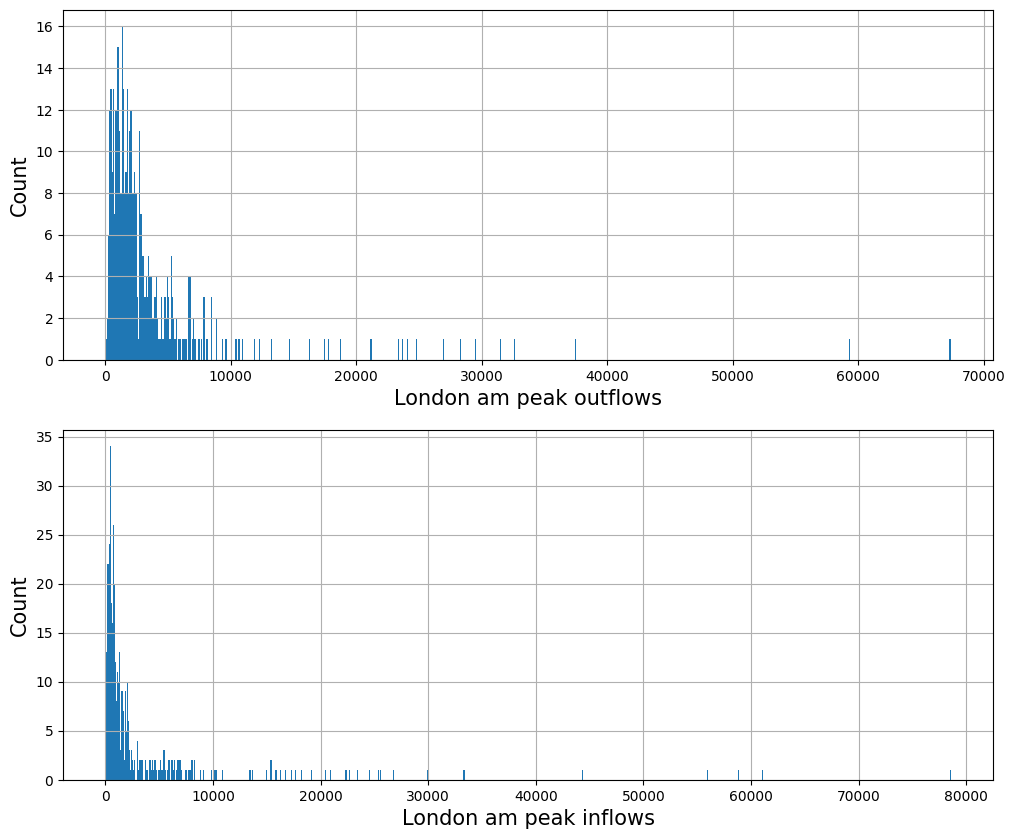

In [55]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows['flows'], bins=int(outflows['flows'].max()/bin_size))
ax[0].set_xlabel('London am peak outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows['flows'], bins=int(inflows['flows'].max()/bin_size))
ax[1].set_xlabel('London am peak inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

In [56]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [57]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

In [58]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


In [59]:
stations.head()

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...",{'labelX': 30},None,1,None,3,POINT (519484.905 179592.101)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]",{'labelX': -30},None,8,None,2/3,POINT (529382.416 186814.396)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...",{'labelX': 30},None,3,None,1,POINT (533886.853 181342.360)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{'labelX': 1, 'labelY': -35}",None,7,None,1,POINT (531462.253 183134.536)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{'labelX': 25, 'labelY': 20}",None,2,None,1,POINT (533623.564 181218.497)


<Axes: >

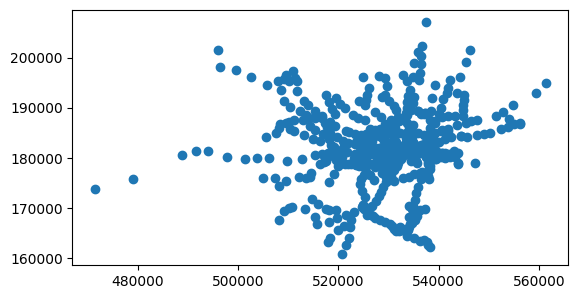

In [60]:
stations.plot()

In [61]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [62]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

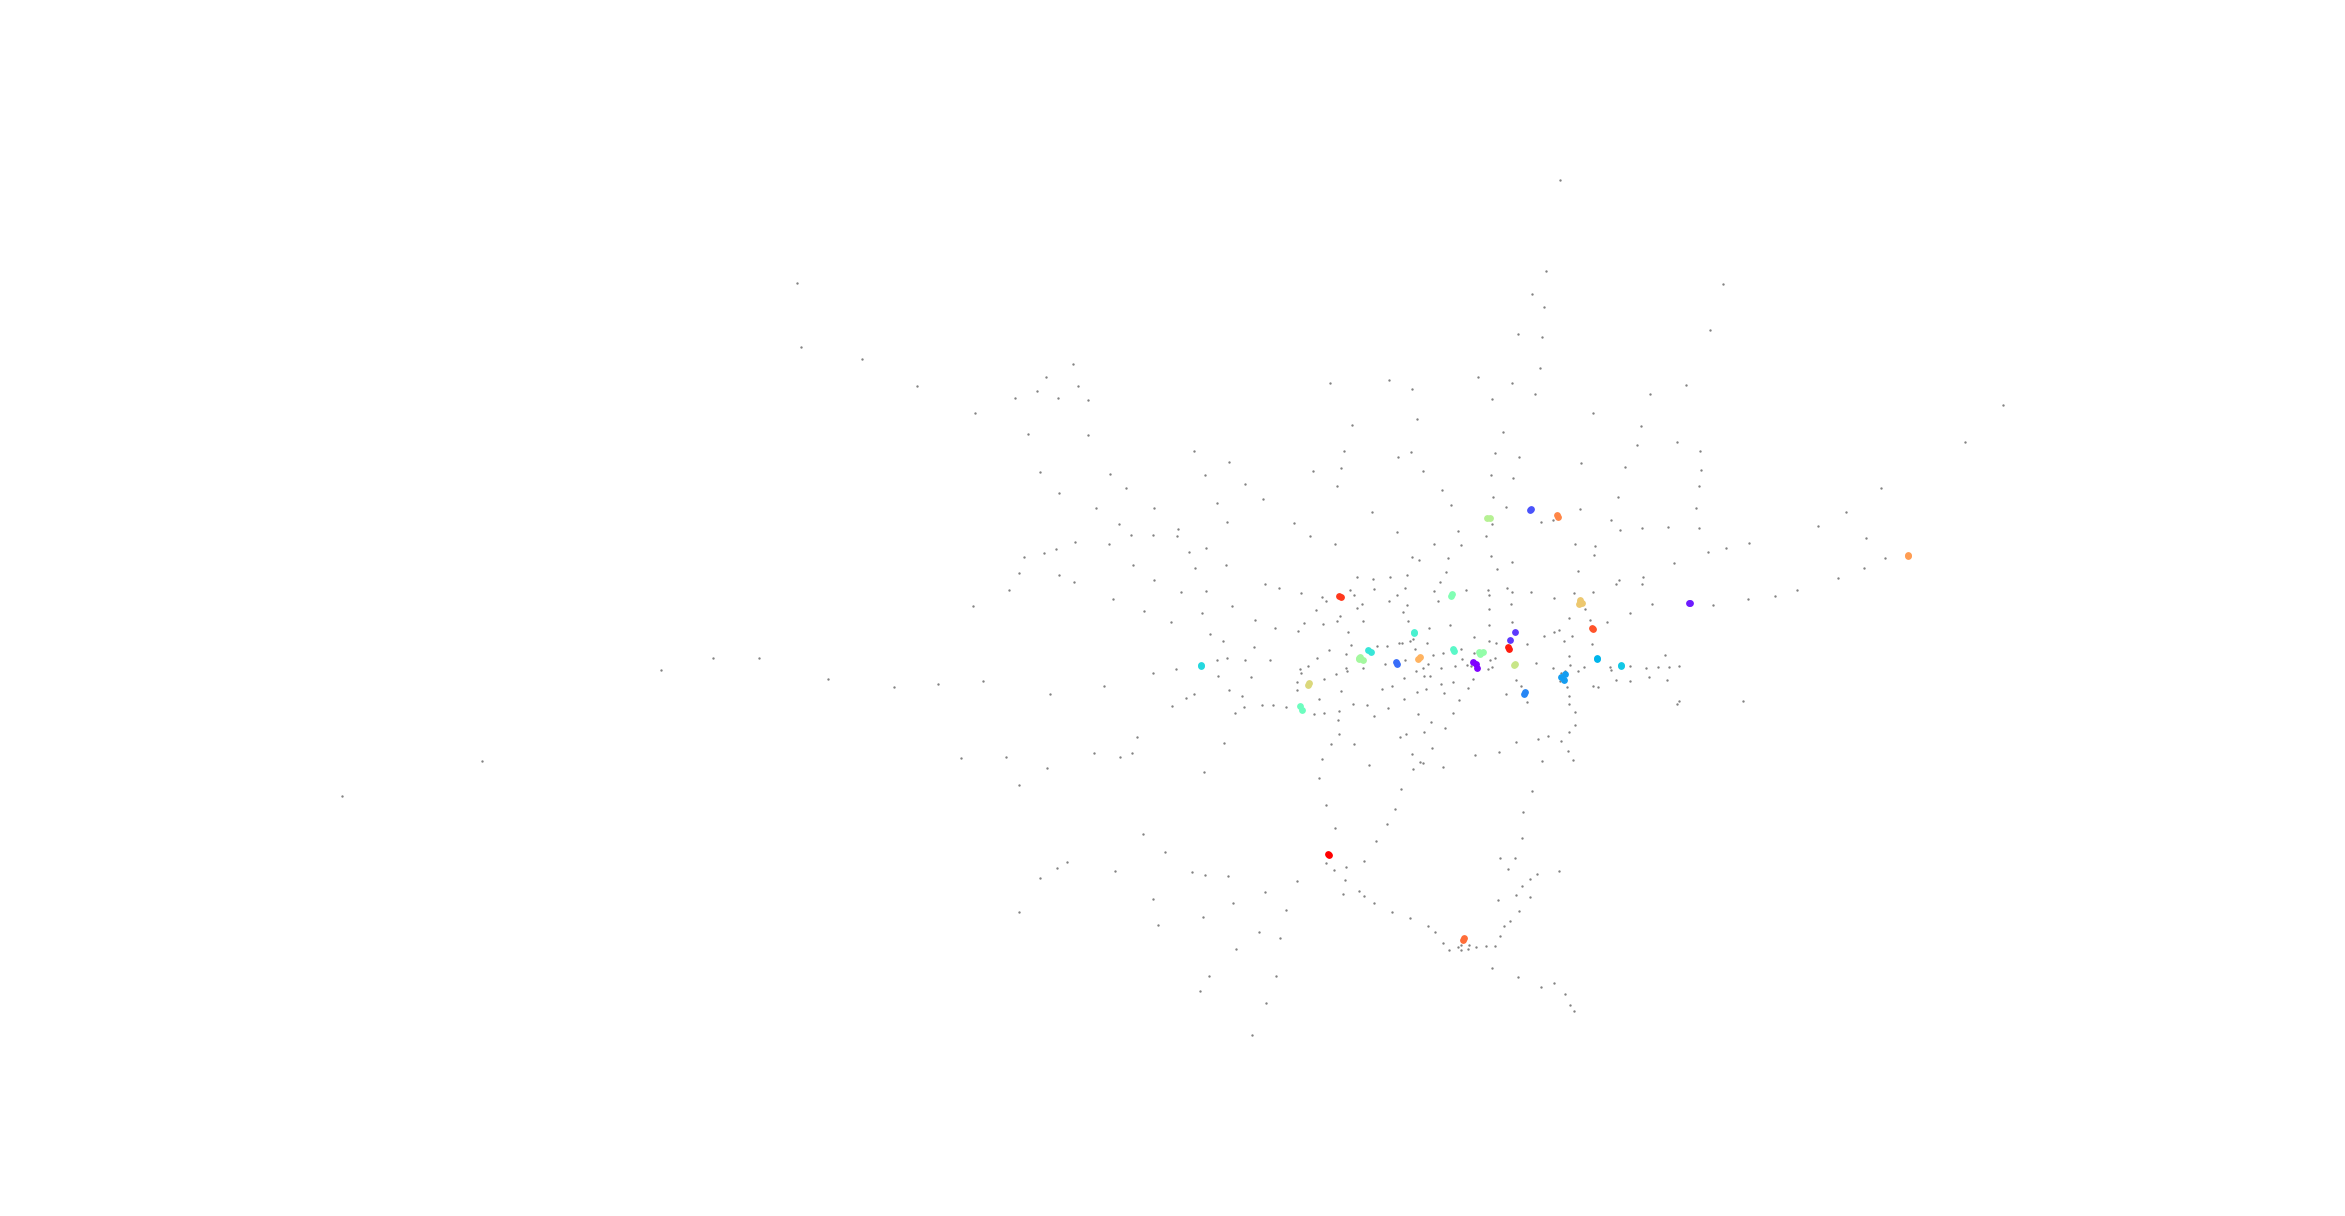

In [63]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

In [64]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [65]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<Axes: >

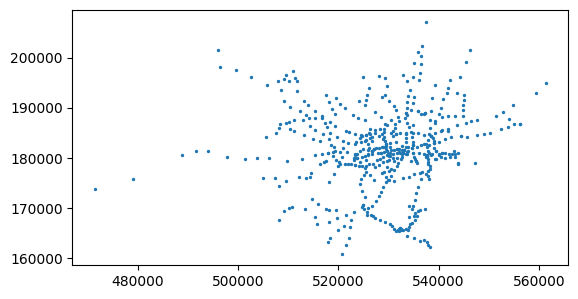

In [66]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

In [67]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Jubilee',
 'Waterloo & City',
 'Crossrail',
 'Crossrail 2',
 'Emirates Air Line',
 'DLR',
 'District',
 'Thameslink 6tph line',
 'Metropolitan',
 'Northern',
 'Bakerloo',
 'TfL Rail',
 'Piccadilly',
 'Circle',
 'Central',
 'East London',
 'Tramlink',
 'London Overground',
 'Hammersmith & City',
 'Victoria']

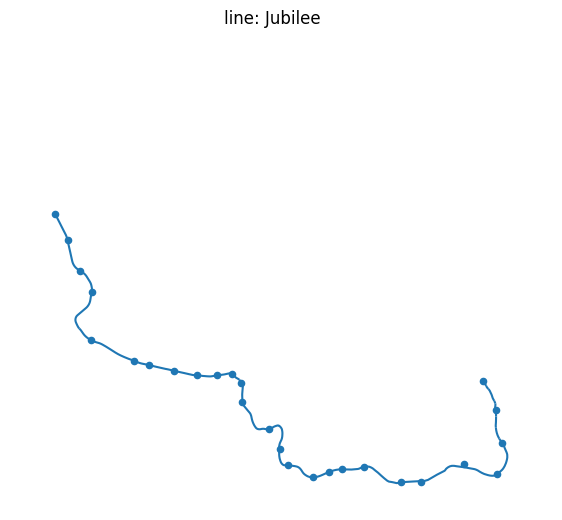

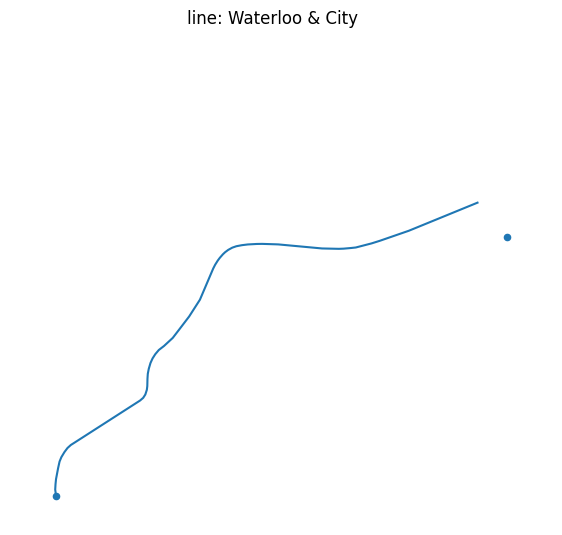

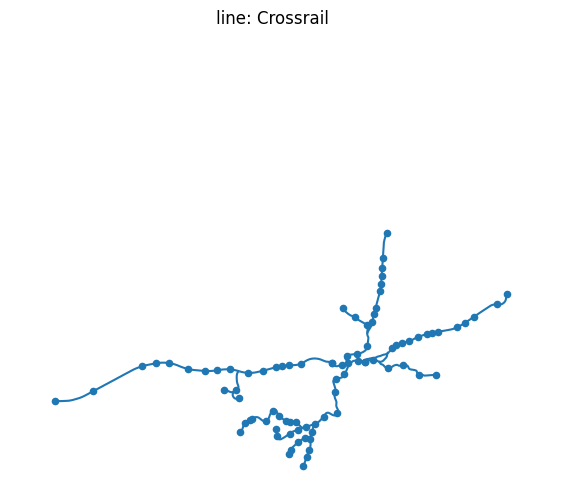

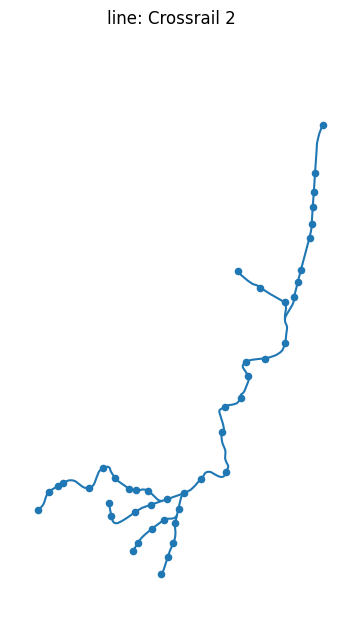

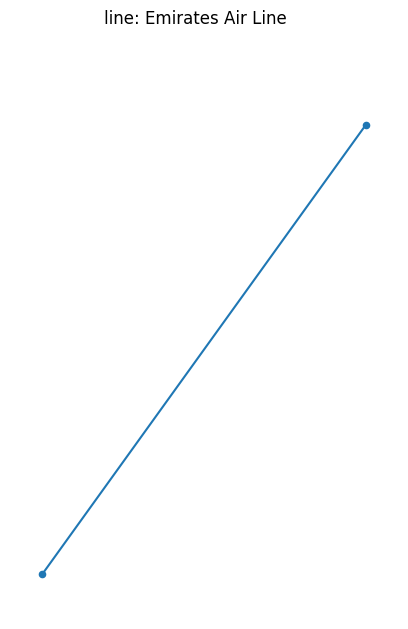

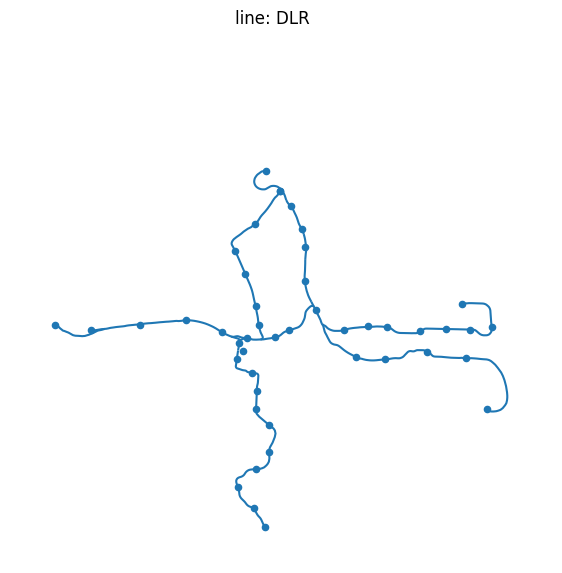

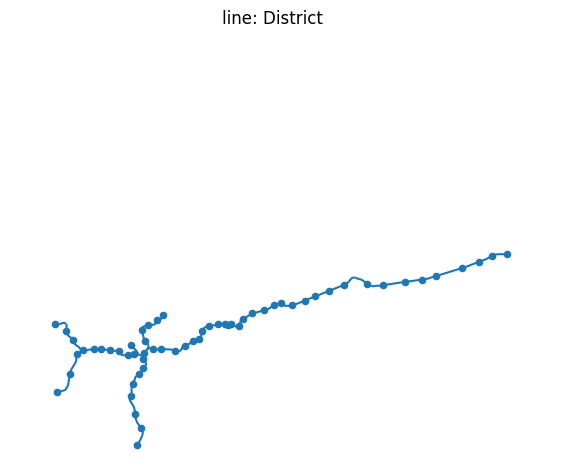

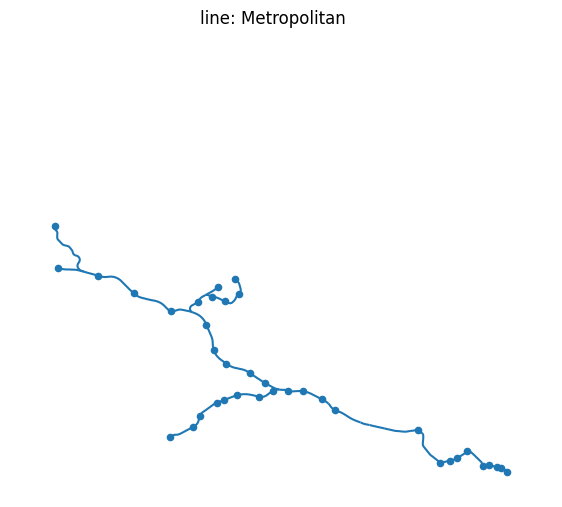

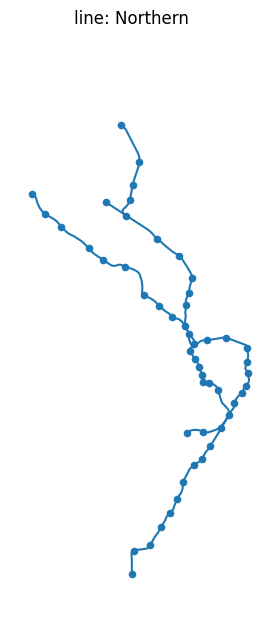

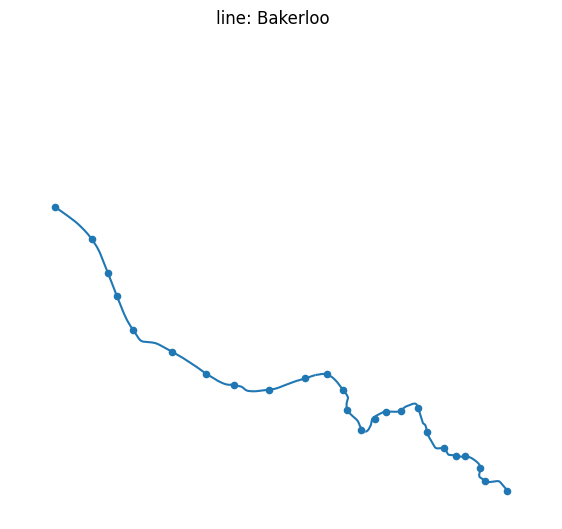

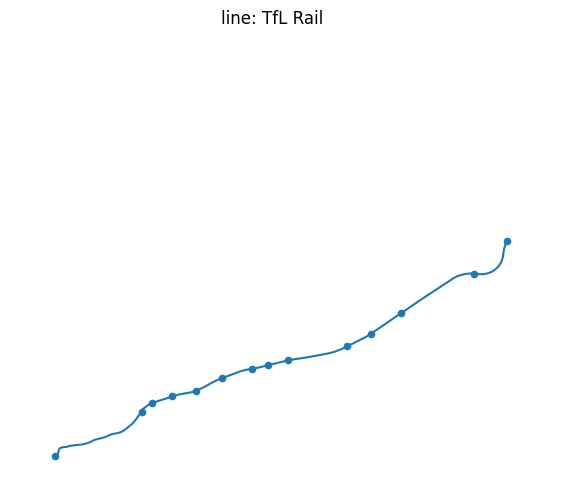

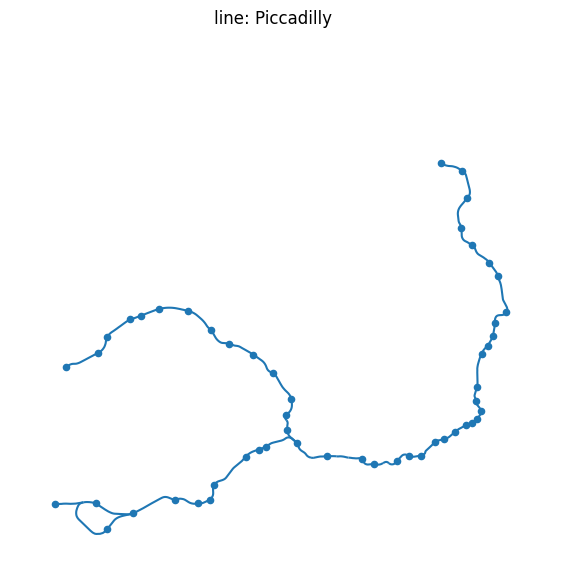

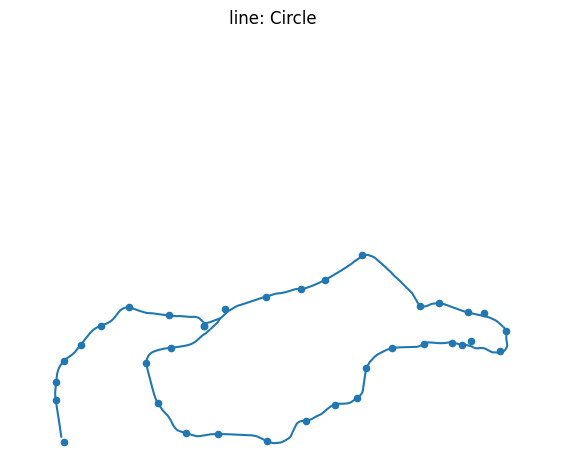

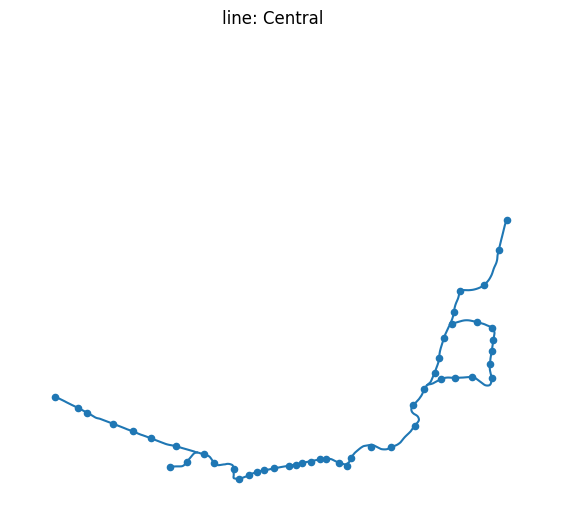

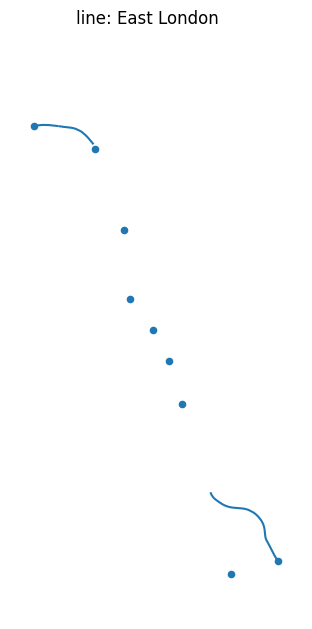

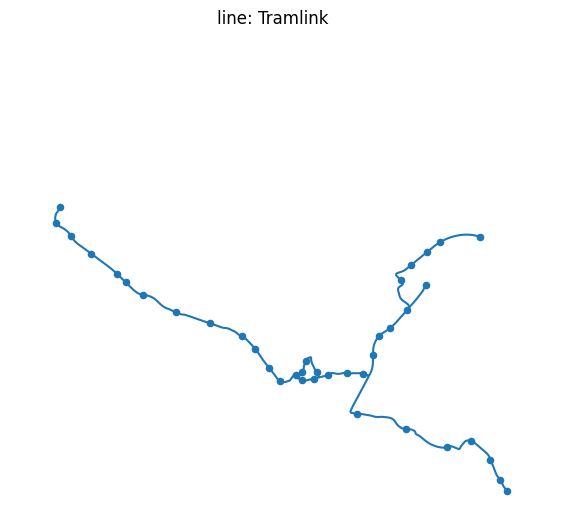

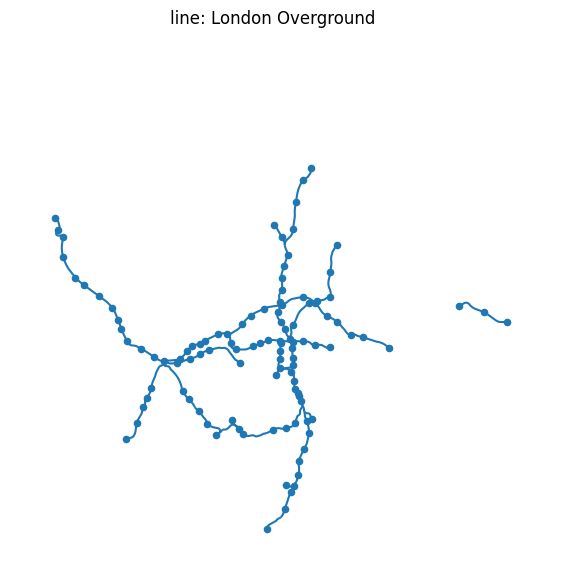

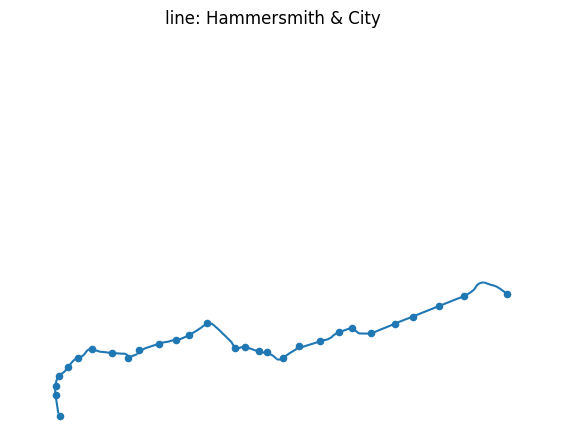

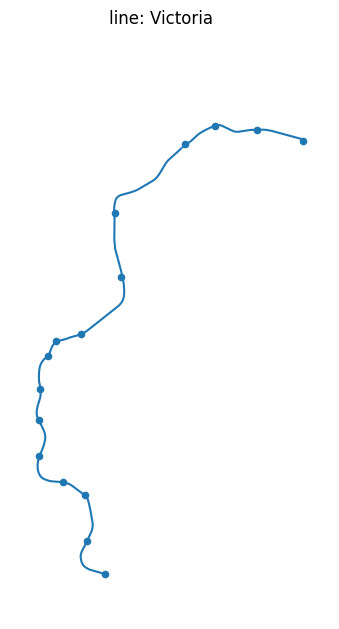

In [68]:
# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [69]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [70]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

Jubilee


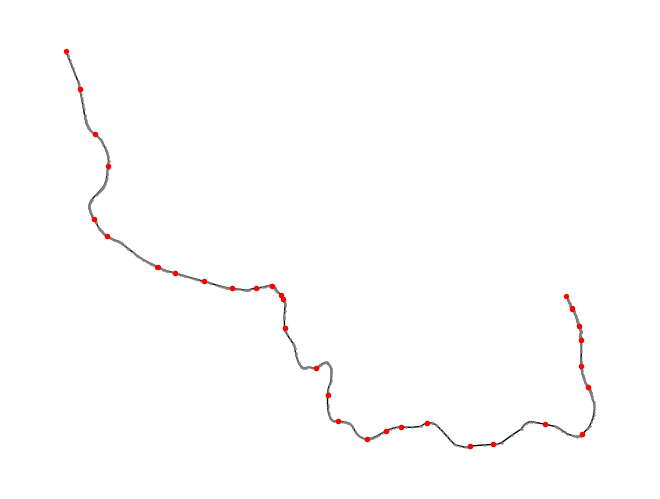

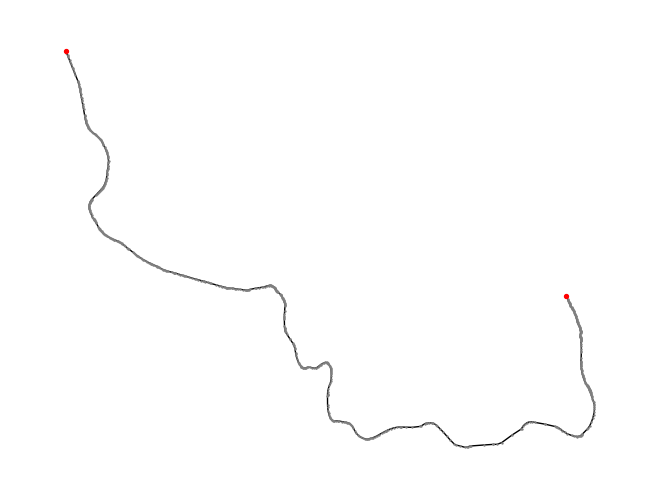

1
Waterloo & City


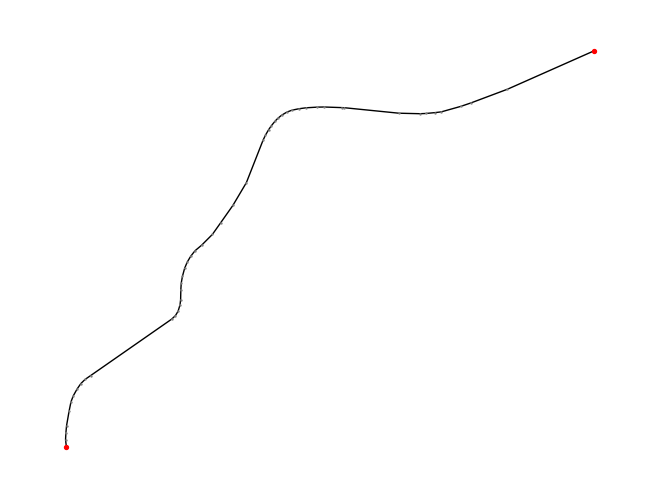

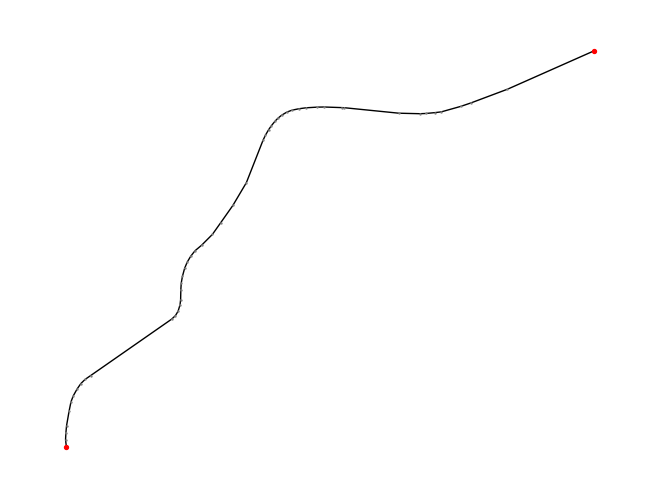

1
DLR


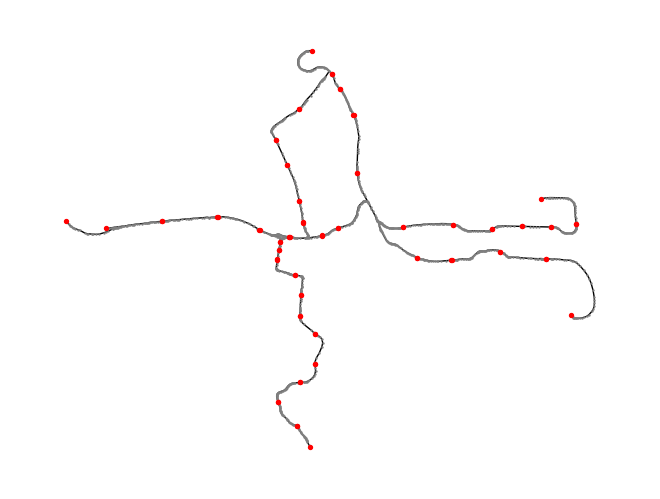

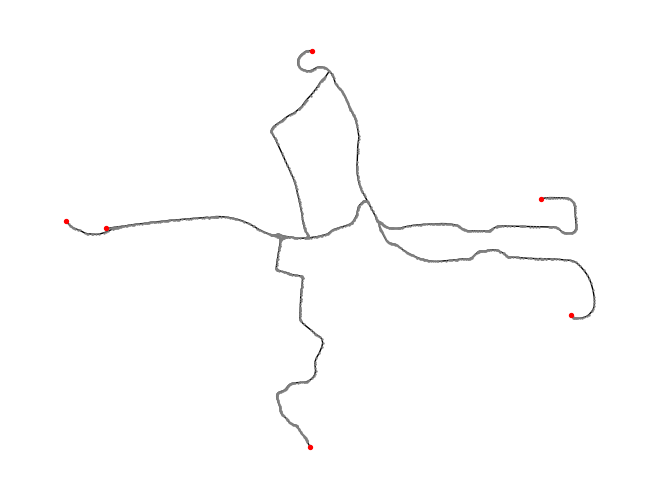

1
District


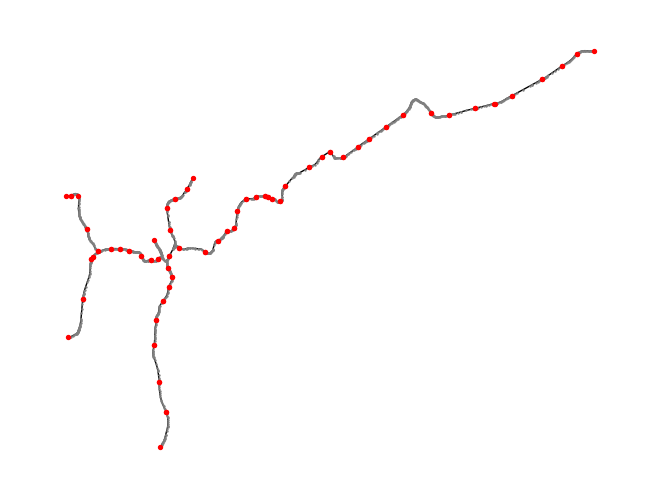

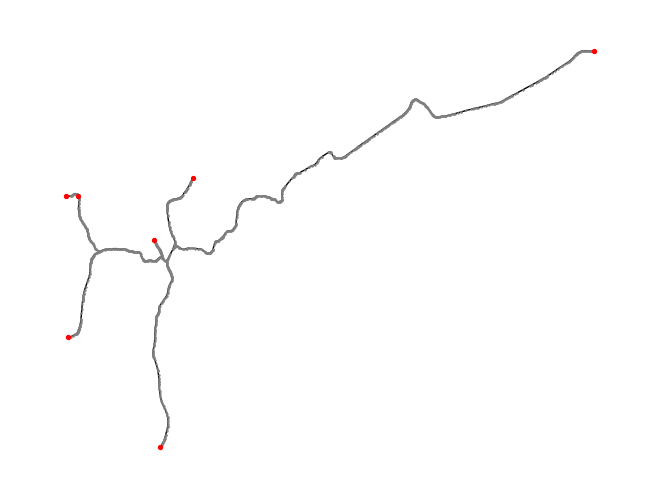

1
Metropolitan


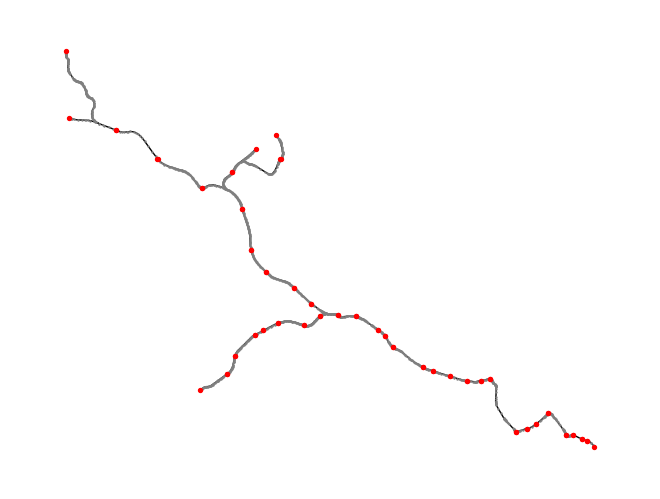

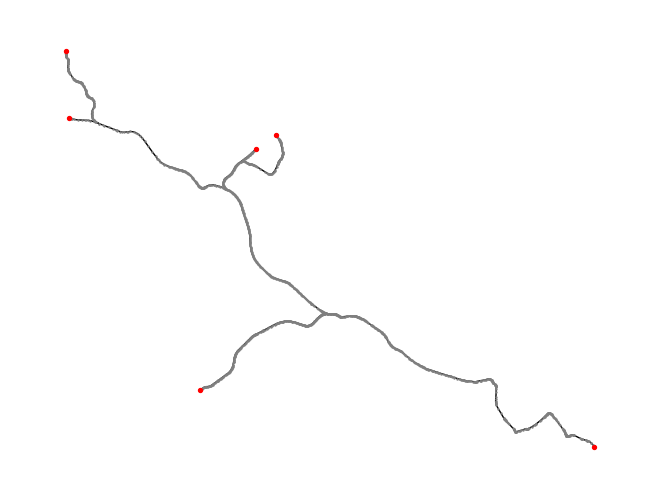

1
Northern


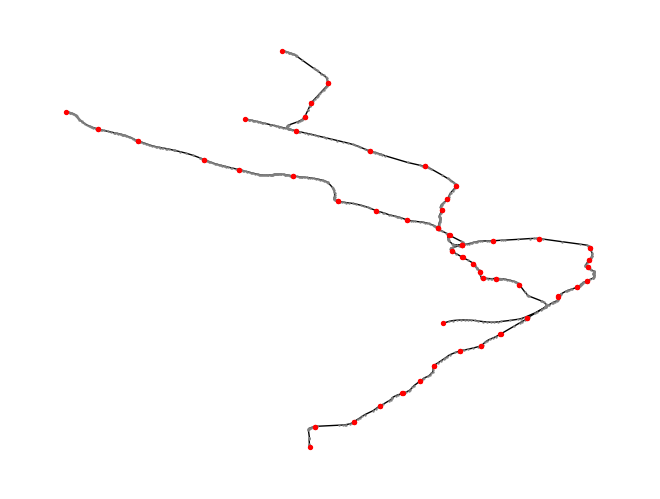

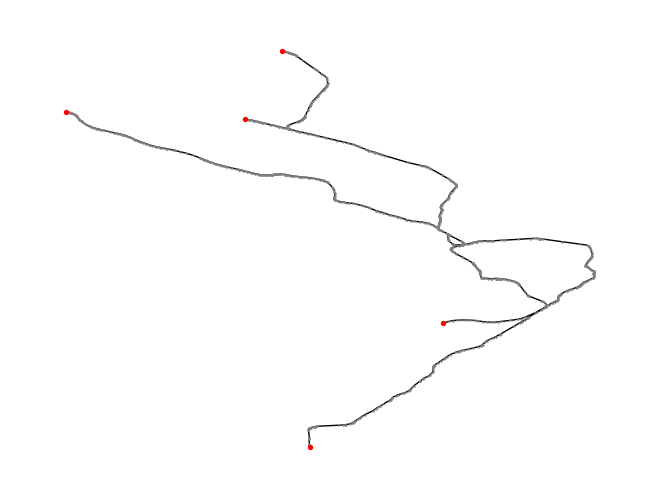

1
Bakerloo


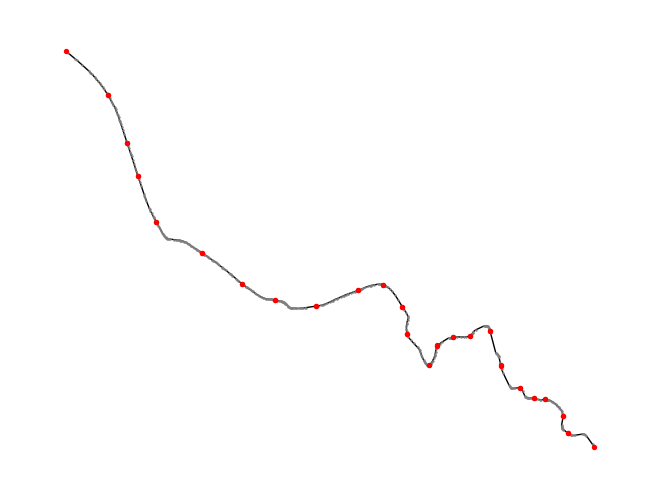

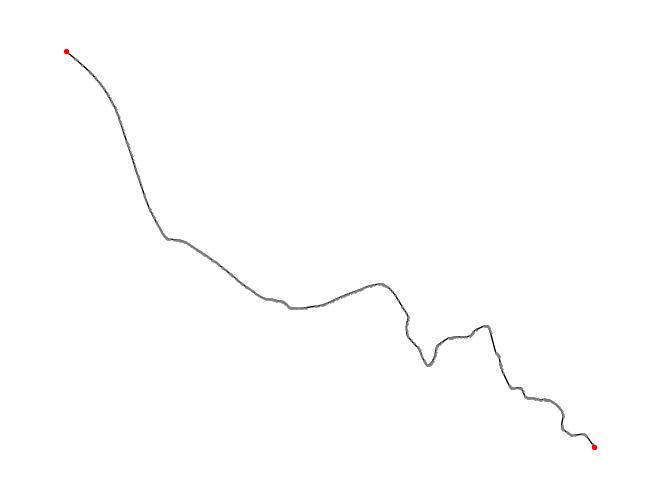

1
TfL Rail


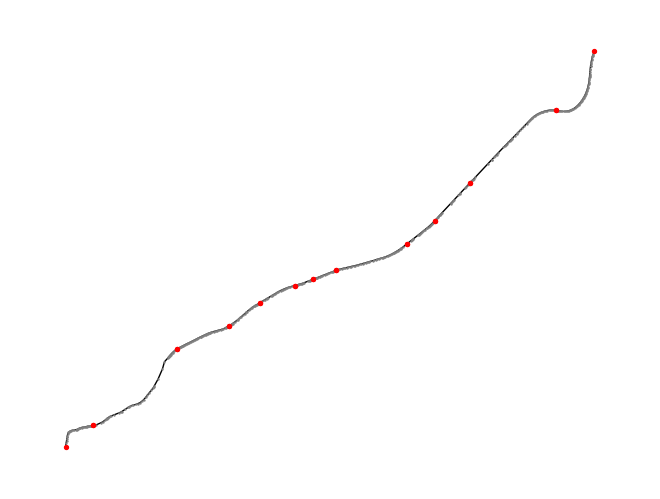

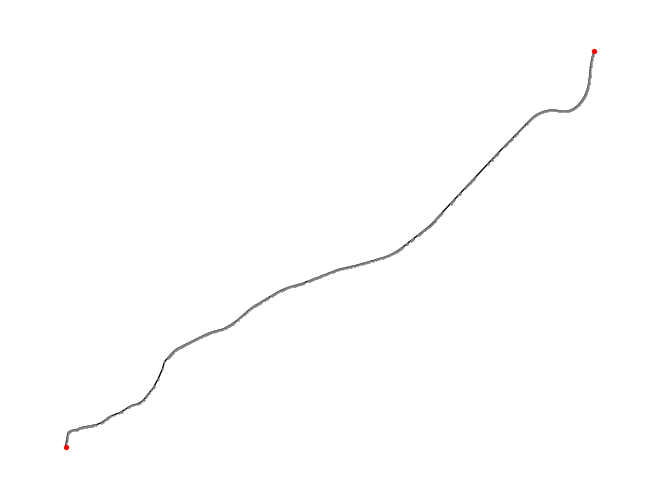

1
Piccadilly


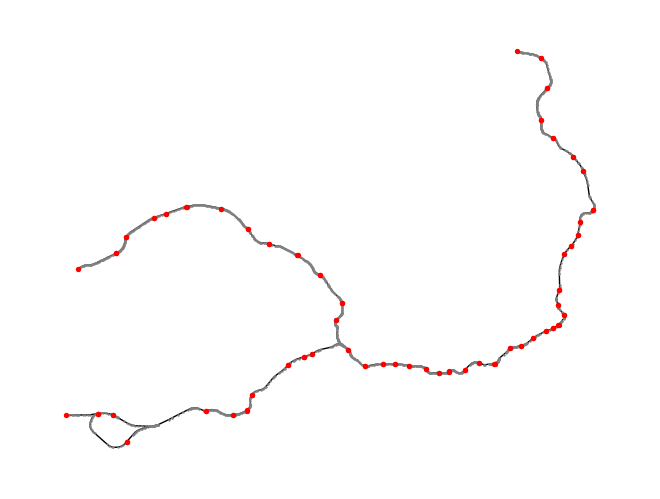

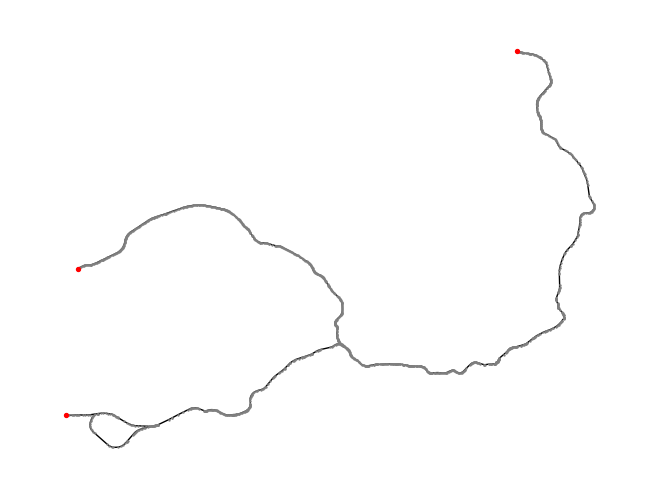

1
Circle


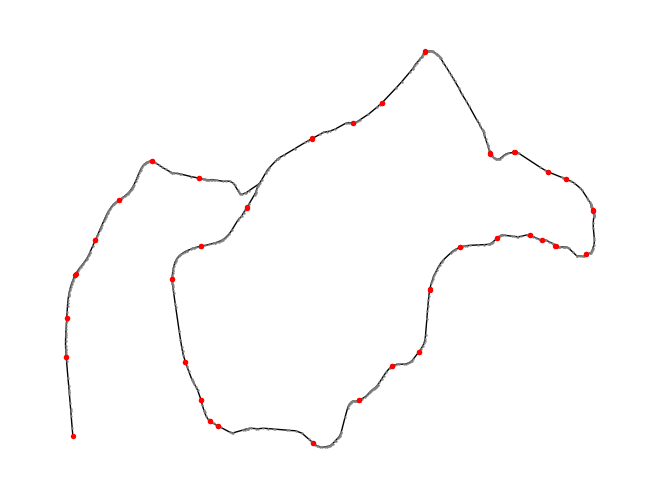

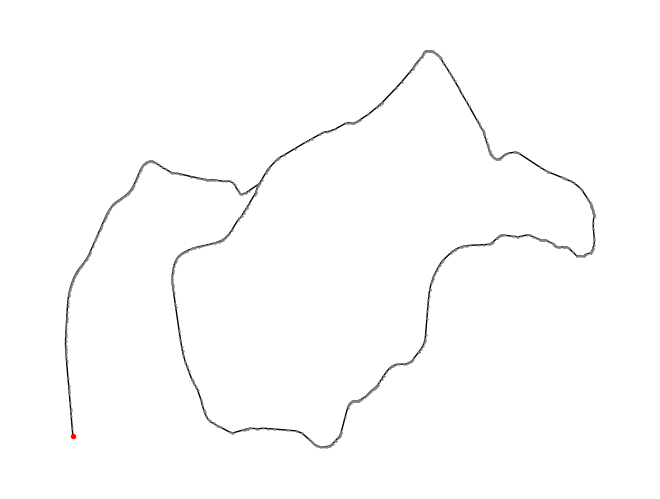

1
Central


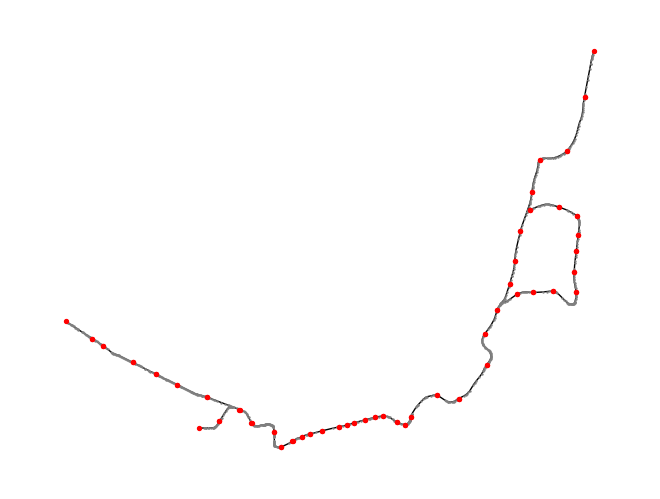

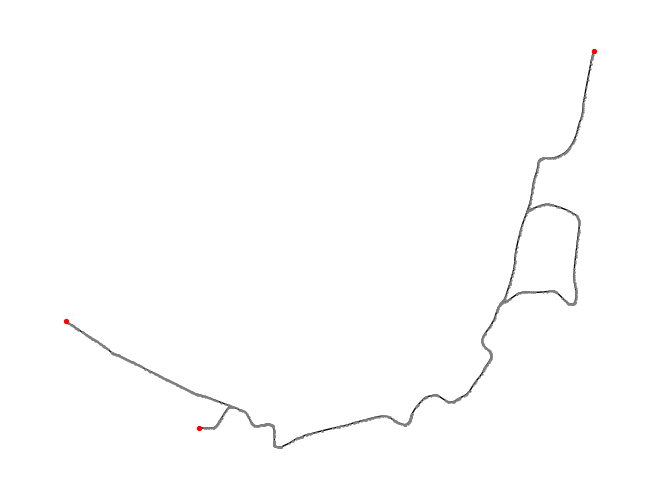

1
London Overground


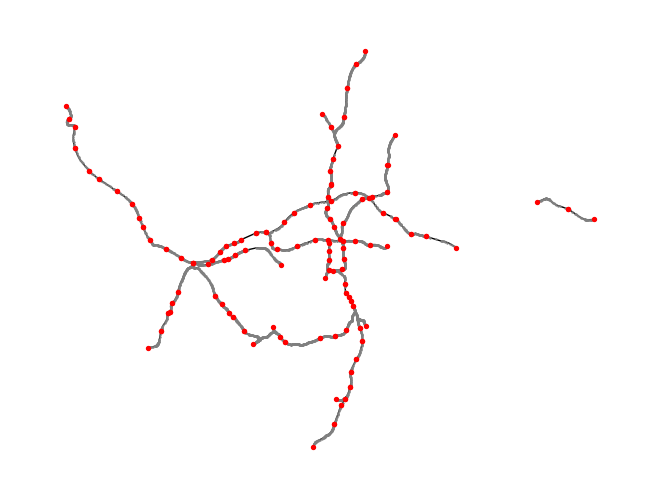

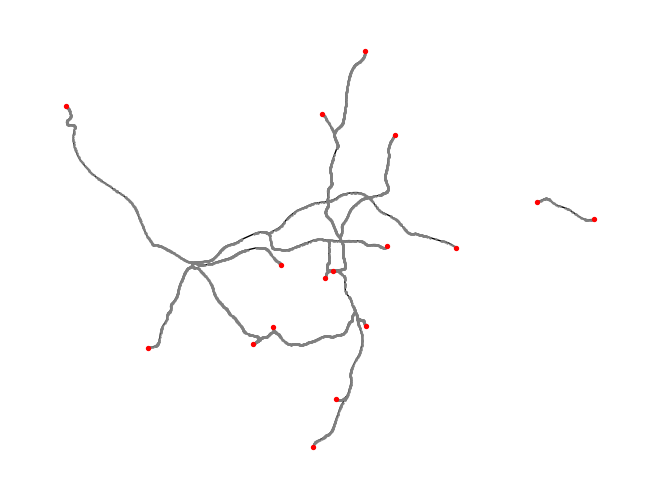

3
Hammersmith & City


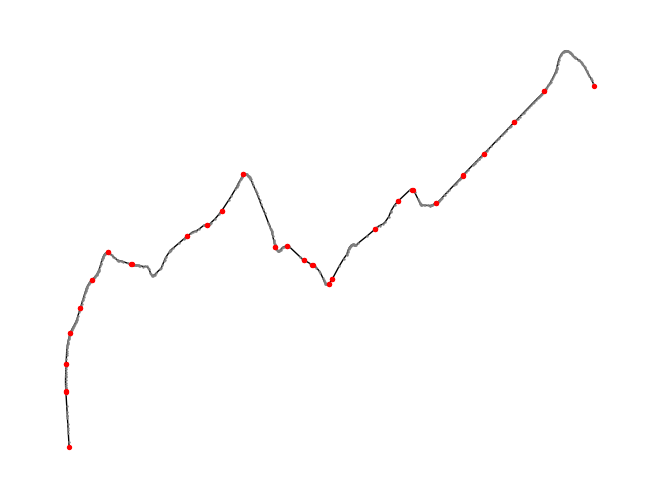

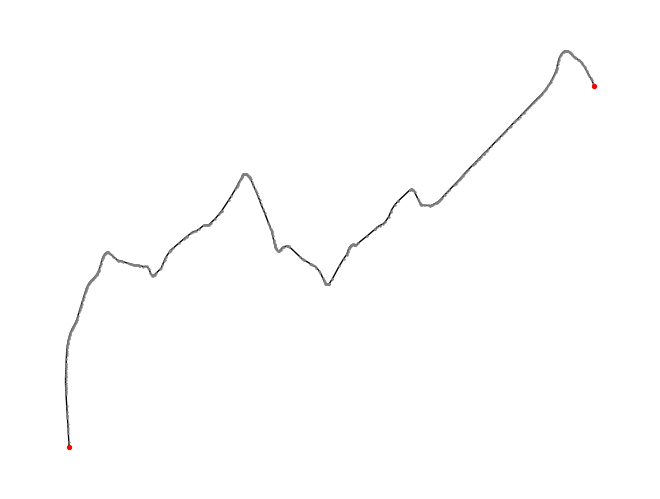

1
Victoria


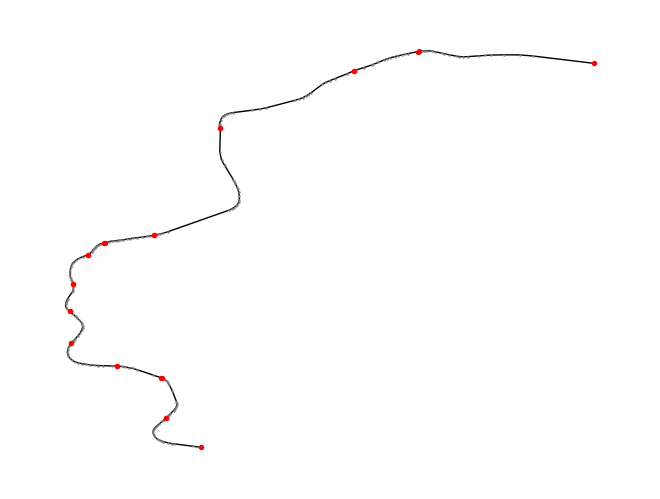

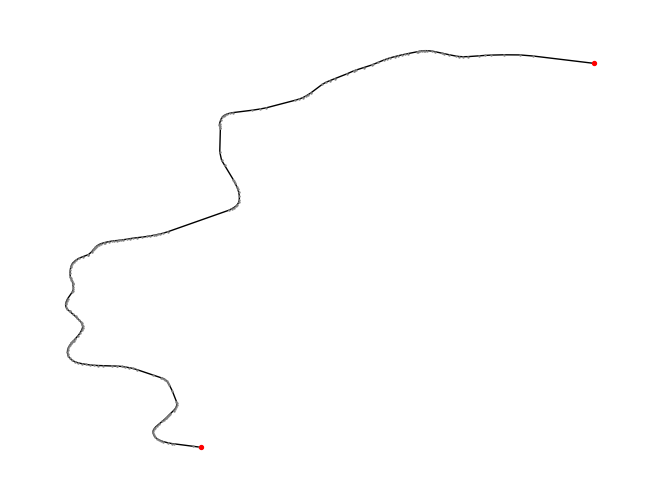

1


In [71]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


In [72]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Jubilee,940GZZLUWYP,940GZZLUKBY,"LINESTRING (519316.559 186389.330, 519359.969 ..."
1,Jubilee,940GZZLUKBY,940GZZLUQBY,"LINESTRING (519359.969 188721.220, 518811.361 ..."
2,Jubilee,940GZZLUQBY,940GZZLUCPK,"LINESTRING (518811.361 189760.507, 518183.300 ..."
3,Jubilee,940GZZLUCPK,940GZZLUSTM,"LINESTRING (518183.300 191257.263, 517580.460 ..."
4,Jubilee,940GZZLUSTD,940GZZLUWHM,"LINESTRING (538524.786 184373.341, 539160.258 ..."


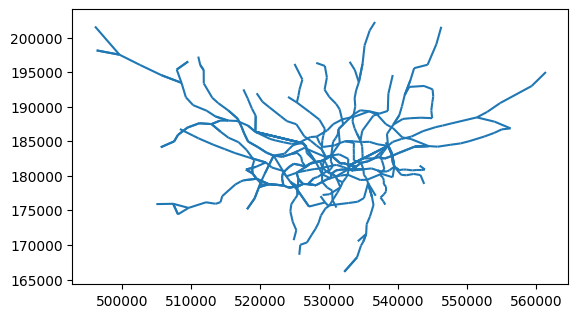

In [73]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

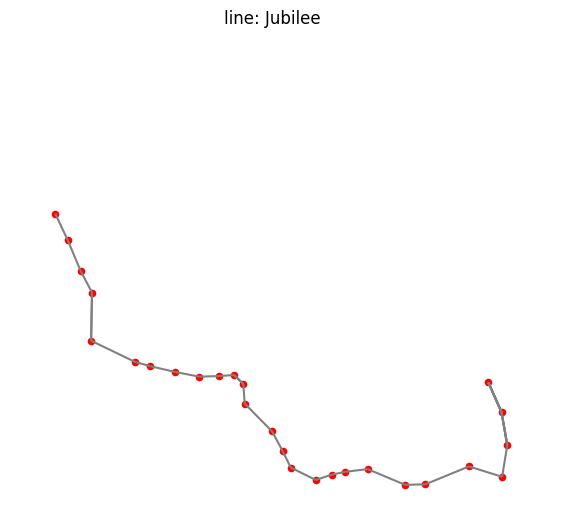

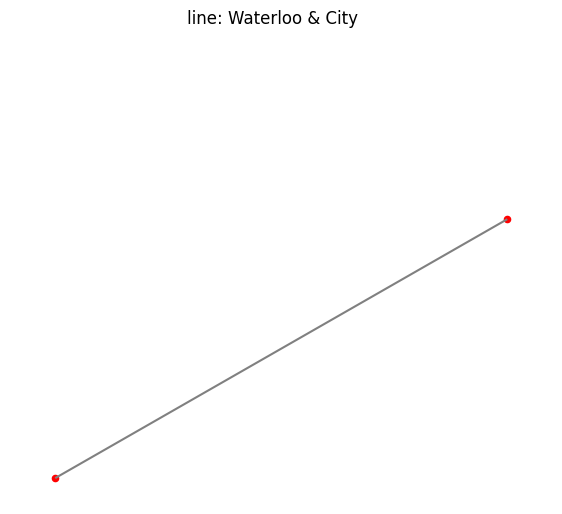

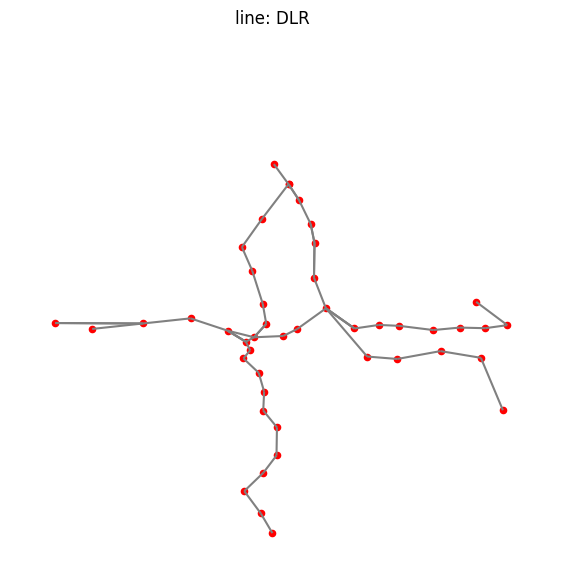

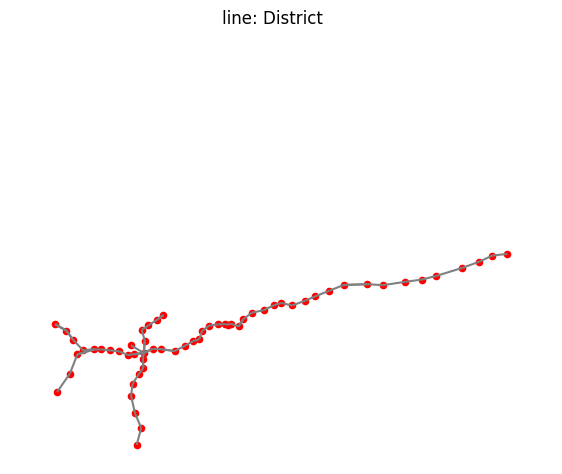

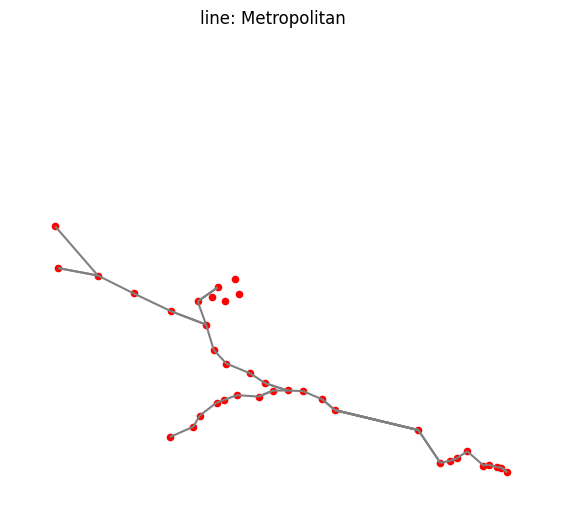

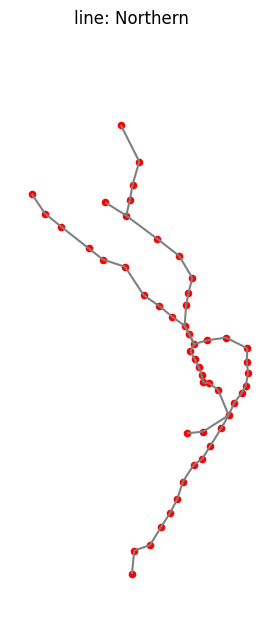

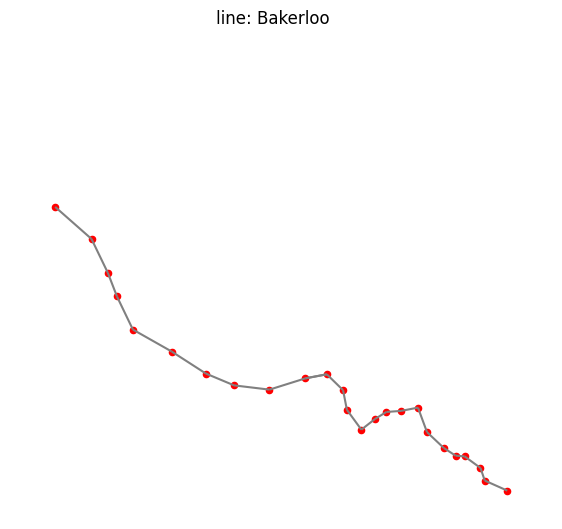

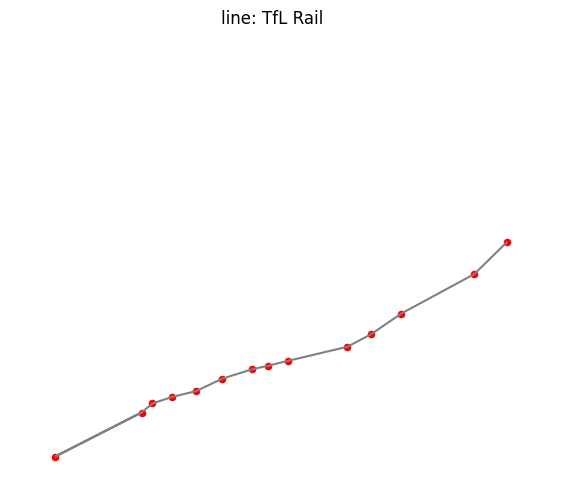

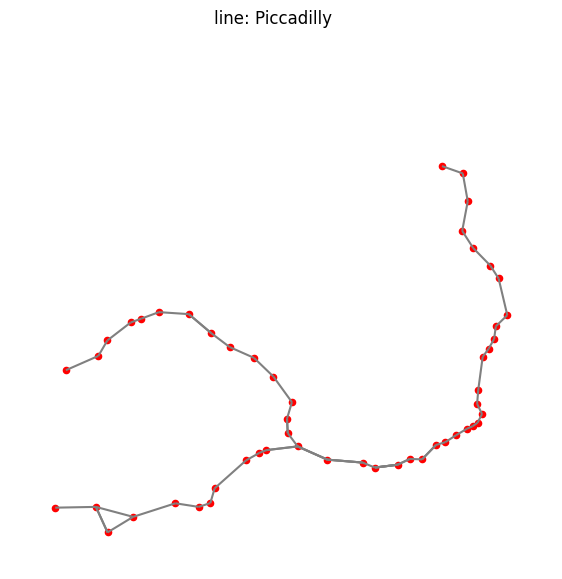

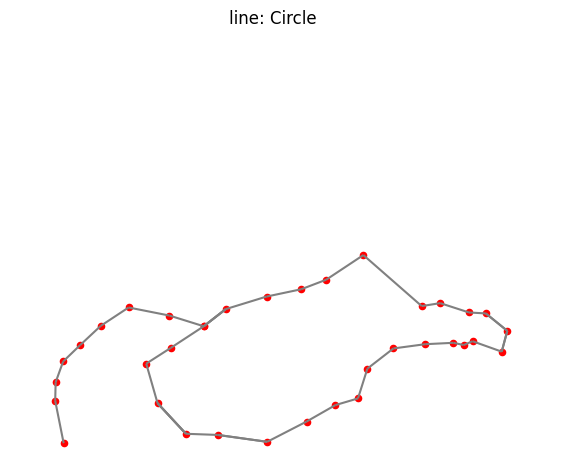

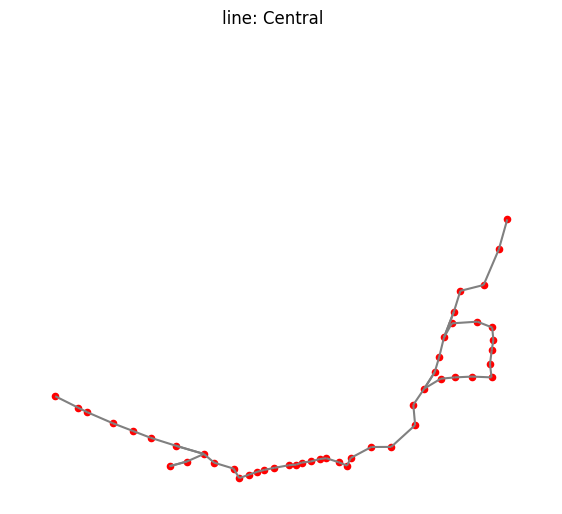

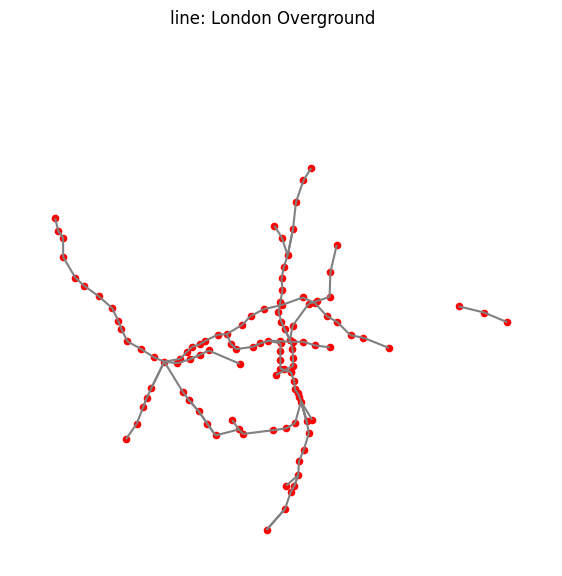

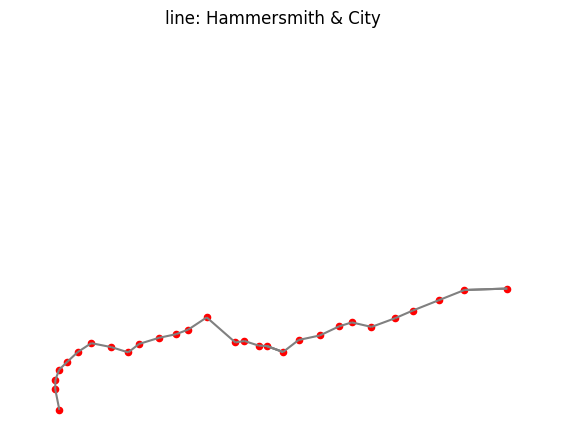

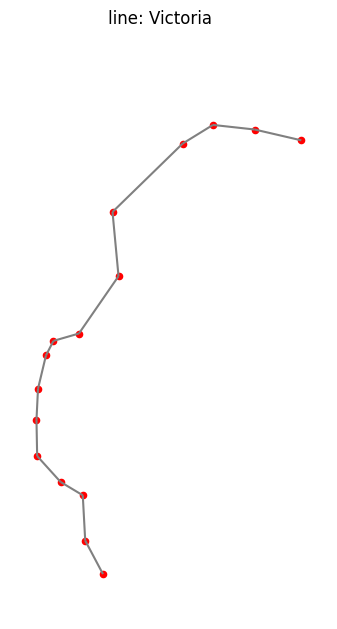

In [74]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<Axes: >

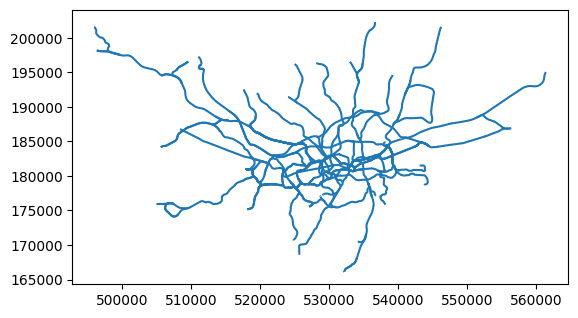

In [75]:
#plot to sanity check
edge_gdf.plot()

In [76]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [77]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Jubilee,940GZZLUWYP,940GZZLUKBY,"LINESTRING (519316.559 186389.330, 519317.885 ...",2916.771558
1,Jubilee,940GZZLUKBY,940GZZLUQBY,"LINESTRING (519359.969 188721.220, 519360.337 ...",1245.995234
2,Jubilee,940GZZLUQBY,940GZZLUCPK,"LINESTRING (518811.361 189760.507, 518812.641 ...",1693.307343
3,Jubilee,940GZZLUCPK,940GZZLUSTM,"LINESTRING (518183.300 191257.263, 518182.820 ...",1419.669476
4,Jubilee,940GZZLUSTD,940GZZLUWHM,"LINESTRING (538524.786 184373.341, 538525.380 ...",1673.509515


In [78]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [79]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [80]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Northern', 'Jubilee', 'Hammersmith & City', 'Bakerloo', 'TfL Rail', 'DLR', 'Waterloo & City', 'Circle', 'Piccadilly', 'District', 'London Overground', 'Central', 'Victoria', 'Metropolitan'}


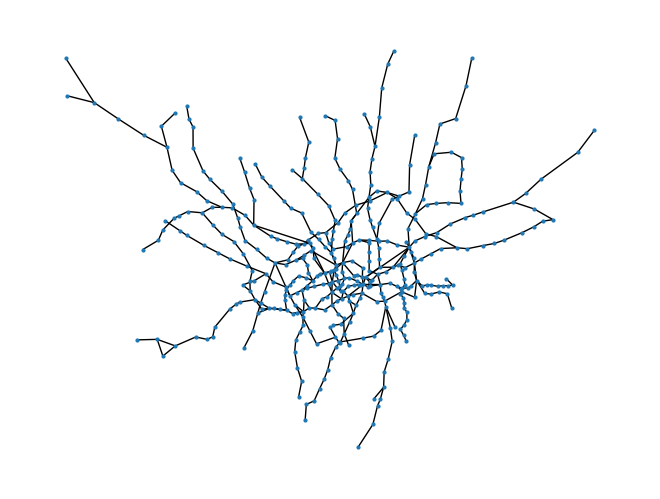

In [81]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [82]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [83]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [84]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496486, 'line_name': 'Metropolitan'})

In [85]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Bond Street', 'Baker Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Edgware Road')]

In [86]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [87]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [88]:
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Green Park,6
Liverpool Street,6
Oxford Circus,6
Earl's Court,6
West Ham,6
Canning Town,6


In [89]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [90]:
network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Hanwell',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Nine Elms',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

In [91]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [92]:
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [93]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Hayes & Harlington',
 'Battersea Power Station',
 'West Ealing',
 'Acton Main Line',
 'Southall',
 'Nine Elms',
 'Hanwell']

In [94]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

In [95]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [96]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [97]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

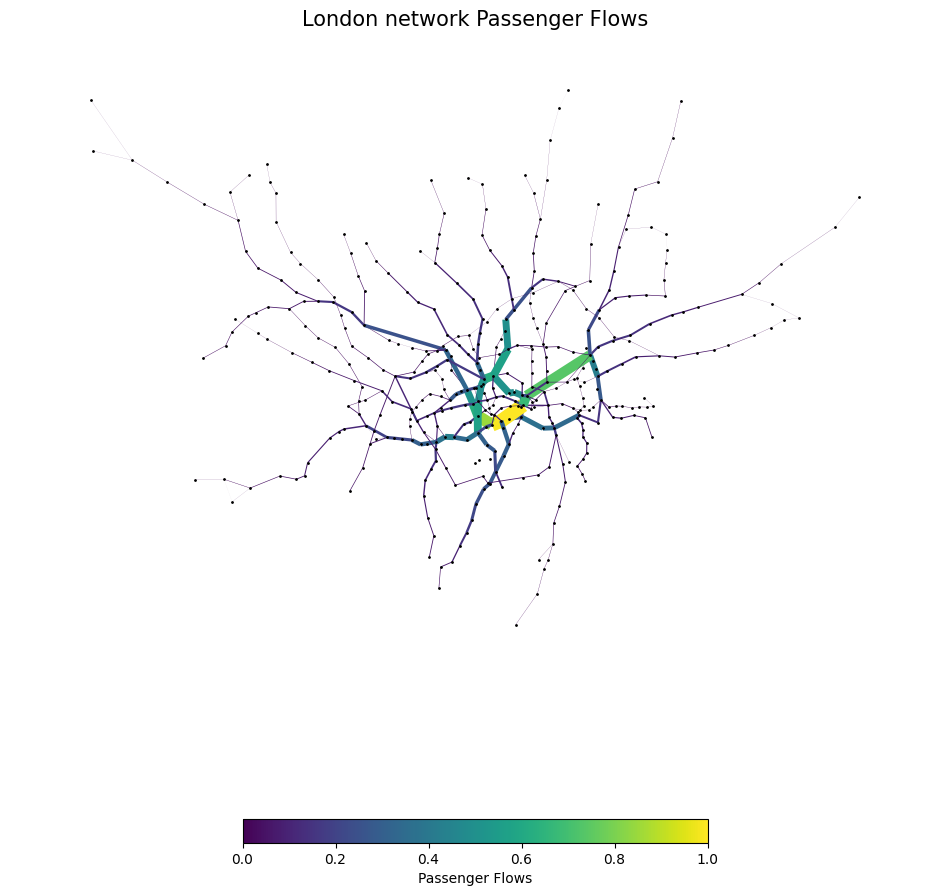

In [98]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [99]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Waterloo', 'Bank and Monument')

In [100]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Kennington', 'Nine Elms')

In [103]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "london_updated.graph")

In [104]:
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_AMpeak, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('OD_matrix.csv')

/tmp/ipykernel_1153/1225588763.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(london_OD_AMpeak,
/tmp/ipykernel_1153/1225588763.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(london_OD_AMpeak,
/tmp/ipykernel_1153/1225588763.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(london_OD_AMpeak,


In [105]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32597
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67372


In [106]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [107]:
#lets add this data as population and jobs
london_OD_AMpeak['population'] = london_OD_AMpeak.station_origin.apply(lambda x: origin[x])
london_OD_AMpeak['jobs'] = london_OD_AMpeak.station_destination.apply(lambda x: destination[x])

In [108]:
#get distance between stations withion the network
london_OD_AMpeak['distance'] = -1
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    london_OD_AMpeak.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...

/tmp/ipykernel_1153/4146044356.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8131.525096866283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  london_OD_AMpeak.loc[i, 'distance'] = distance


In [109]:
london_OD_AMpeak.to_csv('london_flows_new.csv', index=False)

In [110]:
# remove the ALL column and row
OD_melt = OD.iloc[:-1,:-1]
# melt OD back to a long dataframe
OD_melt = OD_melt.reset_index().melt(id_vars='station_origin', value_vars=OD.columns[:-1])
OD_melt.columns = ['station_origin', 'station_destination', 'flows']
# remove the self flows
OD_melt = OD_melt[OD_melt.station_origin != OD_melt.station_destination]
OD_melt.head()


,station_origin,station_destination,flows
1,Acton Central,Abbey Road,0
2,Acton Town,Abbey Road,0
3,Aldgate,Abbey Road,0
4,Aldgate East,Abbey Road,0
5,All Saints,Abbey Road,0


In [111]:
OD_melt['population'] = OD_melt.station_origin.apply(lambda x: origin[x])
OD_melt['jobs'] = OD_melt.station_destination.apply(lambda x: destination[x])

In [112]:
# get distance between stations withion the network
OD_melt['distance'] = -1
for i, row in OD_melt.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    OD_melt.loc[i, 'distance'] = distance

print(OD_melt.shape)
OD_melt.head()

/tmp/ipykernel_1153/1641818707.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23416.724397305643' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  OD_melt.loc[i, 'distance'] = distance


(158802, 6)


,station_origin,station_destination,flows,population,jobs,distance
1,Acton Central,Abbey Road,0,1224,345,23416.724397
2,Acton Town,Abbey Road,0,3745,345,23638.659673
3,Aldgate,Abbey Road,0,2886,345,7888.981451
4,Aldgate East,Abbey Road,0,3172,345,6452.560669
5,All Saints,Abbey Road,0,740,345,5250.389372


In [113]:
OD_melt.sort_values('flows', ascending=False).head(20)

,station_origin,station_destination,flows,population,jobs,distance
6350,Waterloo,Bank and Monument,15946,67372,78549,2542.954444
22310,Waterloo,Canary Wharf,8085,67372,58772,7433.985750
85314,Stratford,Liverpool Street,6946,59311,61122,6698.461270
22159,London Bridge,Canary Wharf,6165,32597,58772,5679.209735
100904,Victoria,Oxford Circus,5181,37517,44368,2220.166284
21999,Canada Water,Canary Wharf,4030,27026,58772,2601.866276
22272,Stratford,Canary Wharf,3875,59311,58772,5482.674320
48093,Liverpool Street,Farringdon,3755,31473,25592,1602.285759
67156,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960
85440,Canada Water,London Bridge,3202,27026,29930,3077.343459


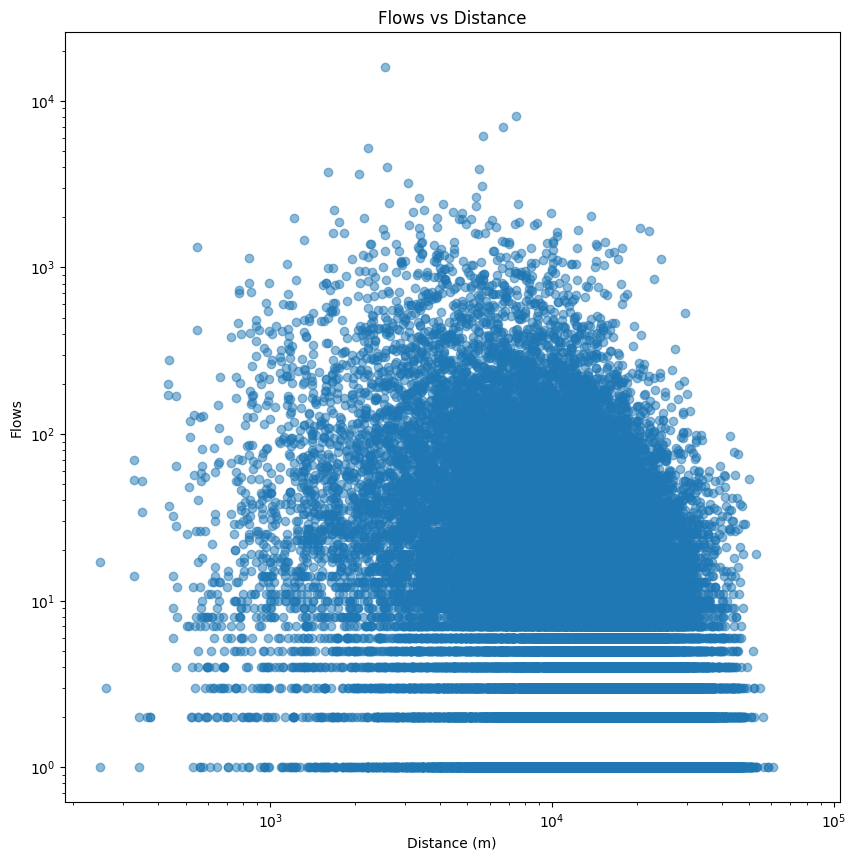

In [114]:
# plot flows against distance, both in the log scale
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(OD_melt.distance, OD_melt.flows, alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Flows')
ax.set_title('Flows vs Distance')

plt.show()

1.1.1 Read the data, and explore the network:


In [30]:
# make multiple copies of the graph
london_graph = nx.read_graphml('london_tubenetwork.graphml')
london_graph3a = nx.read_graphml('london_tubenetwork.graphml')
london_graph3b = nx.read_graphml('london_tubenetwork.graphml')

In [31]:
# add the stations name to the edge attributes from the nodes attributes:
nod_name1={(e1,e2):(london_graph.nodes[e1]['station_name']) for e1, e2 in london_graph.edges()}
nod_name2={(e1,e2):(london_graph.nodes[e2]['station_name']) for e1, e2 in london_graph.edges()}

nx.set_edge_attributes(london_graph,nod_name1,'station_1_')
nx.set_edge_attributes(london_graph,nod_name2,'station_2_')

In [32]:
print(len(dir(london_graph)))
for i in np.random.randint(0, len(dir(london_graph)), 10):
    print(dir(london_graph)[i])

75
adjacency
graph_attr_dict_factory
__eq__
is_multigraph
__doc__
nodes
to_directed
edges
node_attr_dict_factory
remove_nodes_from


In [33]:
print(london_graph.number_of_nodes())
print(london_graph.number_of_edges())

438
486


In [23]:
# To check node attributes:
list(london_graph.nodes(data = True))[0]

('910GCAMHTH',
 {'station_name': 'Cambridge Heath',
  'lines': 'London Overground',
  'coords': (534825.0140298002, 183290.813466997)})

In [21]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in london_graph.nodes():
    london_graph.nodes[node]['coords'] = eval(london_graph.nodes[node]['coords'])
    

In [22]:
# To check edges attributes:
list(london_graph.edges(data = True))[0]

('910GCAMHTH',
 '910GBTHNLGR',
 {'length': 1076.0822006959384,
  'name': 'London Overground',
  'line_id': 'LeaValleyLine1',
  'station_1_': 'Cambridge Heath',
  'station_2_': 'Bethnal Green'})

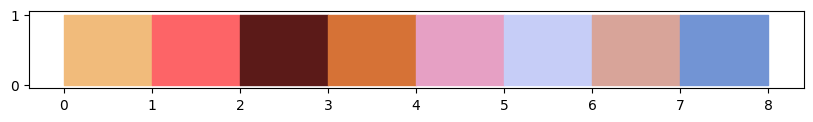

In [24]:
# Now import my favourite colour palette:
grandBudapest_colors = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236", "#E6A0C4", "#C6CDF7", "#D8A499", "#7294D4"]

# Now let's plot color pallette
plt.figure(figsize=(10, 1))
for i, color in enumerate(grandBudapest_colors):
    plt.fill_between([i, i + 1], 0, 1, color=color)


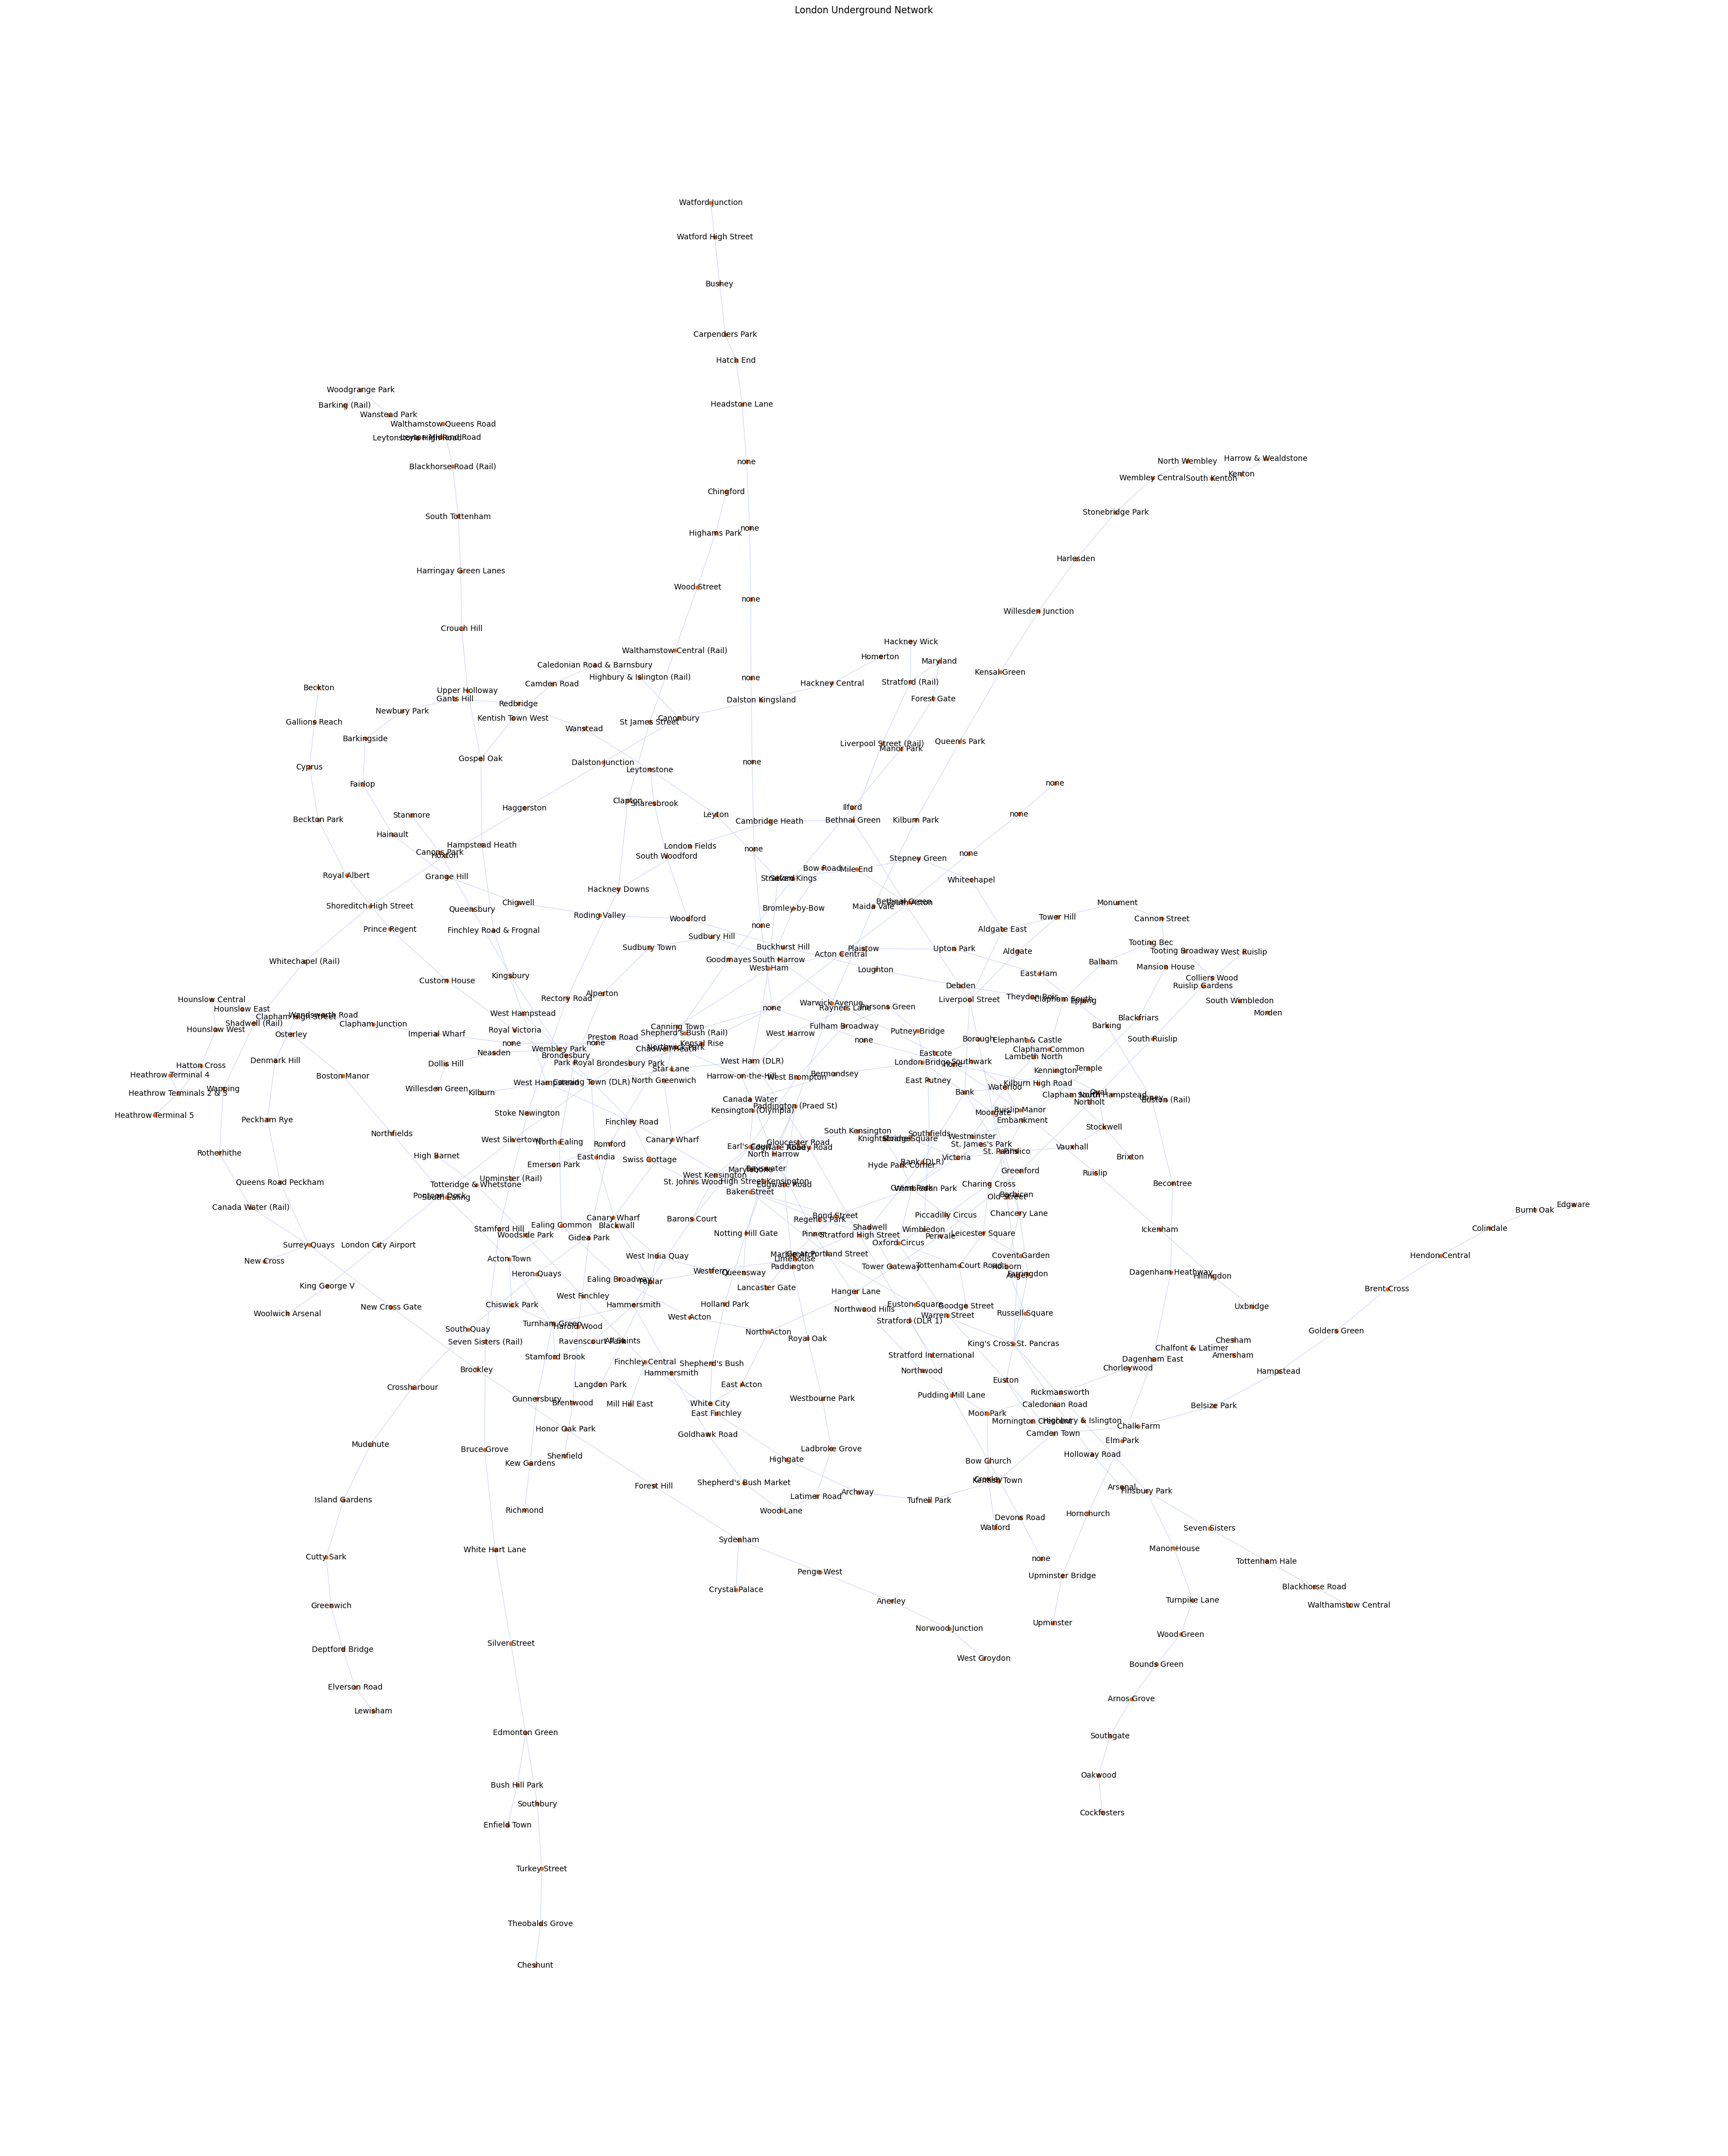

In [25]:
# Draw the network
plt.figure(figsize=(40, 50))
node_labels = nx.get_node_attributes(london_graph, 'station_name')

pos = nx.spring_layout(london_graph, seed=42)  # For consistent layout
nx.draw_networkx_nodes(london_graph, pos, node_size= 20, node_color = grandBudapest_colors[3])
nx.draw_networkx_edges(london_graph, pos, alpha=0.8, edge_color=grandBudapest_colors[5], 
        width=0.8)
# Draw node labels
nx.draw_networkx_labels(london_graph, pos, node_labels, font_size=10, font_color='black')
plt.title("London Underground Network")
plt.axis('off')  # Turn off the axis
plt.show()


In [26]:
 #We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(london_graph)
df[0:20]

,source,target,station_2_,station_1_,length,line_id,name
0,910GCAMHTH,910GBTHNLGR,Bethnal Green,Cambridge Heath,1076.082201,LeaValleyLine1,London Overground
1,910GCAMHTH,910GLONFLDS,London Fields,Cambridge Heath,970.949720,LeaValleyLine2,London Overground
2,910GBTHNLGR,910GLIVST,Liverpool Street (Rail),Bethnal Green,1813.304143,LivStBeth,London Overground
3,910GBTHNLGR,940GZZLUBLG,Bethnal Green,Bethnal Green,481.514661,NaN,NaN
4,910GLONFLDS,910GHAKNYNM,Hackney Downs,London Fields,917.502798,LeaValleyLine3,London Overground
5,910GHAKNYNM,910GRCTRYRD,Rectory Road,Hackney Downs,1178.231752,LeaValleyLine4,London Overground
6,910GHAKNYNM,910GCLAPTON,Clapton,Hackney Downs,1432.298268,ChingfordSpur1,London Overground
7,910GRCTRYRD,910GSTKNWNG,Stoke Newington,Rectory Road,775.442407,LeaValleyLine5,London Overground
8,910GSTKNWNG,910GSTMFDHL,Stamford Hill,Stoke Newington,1200.722885,LeaValleyLine6,London Overground
9,910GSTMFDHL,910GSEVNSIS,Seven Sisters (Rail),Stamford Hill,1001.203674,LeaValleyLine7,London Overground


In [52]:
#if want to know what is the maximum distance between stations
max_dist=max({weight for e1, e2, weight in london_graph.edges(data='length')})

#This distance in given in meters
#if want to know the name of stations which are further away from each other
furthest_stat = [(d['station_1_'],d['station_2_']) for  u,v,d in london_graph.edges(data=True) if d['length'] == max_dist]

#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(d['station_1_'],d['station_2_']) for  u,v,d in london_graph.edges(data=True) if d['station_1_'] == 'Baker Street'or d['station_2_'] == 'Baker Street']
(max_dist,furthest_stat,Baker_Street)

(7113.318903338077,
 [('Wembley Park', 'Finchley Road')],
 [('Edgware Road', 'Baker Street'),
  ('Baker Street', 'Great Portland Street'),
  ('Baker Street', 'Bond Street'),
  ('Baker Street', "St. John's Wood"),
  ('Baker Street', 'Finchley Road'),
  ('Baker Street', 'Marylebone'),
  ('Baker Street', "Regent's Park")])

1.1.2 Centrality Measures
1) Degree Centrality

In [27]:
degree_centrality = nx.degree_centrality(london_graph)
nx.set_node_attributes(london_graph,dict(degree_centrality),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=london_graph.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(london_graph, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(london_graph, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,station_name,degree
940GZZLUKSX,King's Cross St. Pancras,0.016018
940GZZLUBST,Baker Street,0.016018
940GZZLUOXC,Oxford Circus,0.013730
940GZZLUGPK,Green Park,0.013730
940GZZLUBNK,Bank,0.013730
940GZZLUECT,Earl's Court,0.013730
940GZZLUWLO,Waterloo,0.013730
940GZZLUTNG,Turnham Green,0.011442
940GZZDLCGT,Canning Town (DLR),0.011442
940GZZLULVT,Liverpool Street,0.011442


In [28]:
df_sorted[0:20]

,station_name,degree
940GZZLUKSX,King's Cross St. Pancras,0.016018
940GZZLUBST,Baker Street,0.016018
940GZZLUOXC,Oxford Circus,0.013730
940GZZLUGPK,Green Park,0.013730
940GZZLUBNK,Bank,0.013730
940GZZLUECT,Earl's Court,0.013730
940GZZLUWLO,Waterloo,0.013730
940GZZLUTNG,Turnham Green,0.011442
940GZZDLCGT,Canning Town (DLR),0.011442
940GZZLULVT,Liverpool Street,0.011442


2) Betweeness centrality


In [8]:
# Recompute the centrality measures

betweenness_centrality = nx.betweenness_centrality(london_graph)
closeness_centrality = nx.closeness_centrality(london_graph)

# Sort and get the top 10 nodes for each centrality measure
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

#

#(sorted_degree, sorted_betweenness, sorted_closeness)


In [12]:
london_graph

In [9]:
pd.DataFrame.from_dict(sorted_degree,columns=['degree centrality'],orient='index')
pd.DataFrame.from_dict(sorted_betweenness,columns=['betweeness centrality'],orient='index')
pd.DataFrame.from_dict(sorted_closeness,columns=['closeness centrality'],orient='index')

AttributeError: 'list' object has no attribute 'values'

Delta Centrality

In [ ]:
# Compute initial betweenness centrality
initial_betweenness = nx.betweenness_centrality(G)

# Initialize a dictionary to store delta centrality
delta_centrality = {}

# Iterate over all nodes to compute delta centrality
for node in G.nodes():
    # Create a copy of the graph without the current node
    G_copy = copy.deepcopy(G)
    G_copy.remove_node(node)
    
    # Recompute betweenness centrality without the node
    new_betweenness = nx.betweenness_centrality(G_copy)
    
    # Calculate the difference and store it
    delta_centrality[node] = sum(abs(initial_betweenness[n] - new_betweenness.get(n, 0)) for n in initial_betweenness)

# Sort nodes by their delta centrality
sorted_delta_centrality = sorted(delta_centrality.items(), key=lambda x: x[1], reverse=True)

Delta centrality

In [ ]:
import networkx as nx
import copy

# Load your network
G = nx.read_graphml('path_to_your_graphml_file.graphml')

# Compute initial betweenness centrality
initial_betweenness = nx.betweenness_centrality(G)

# Initialize a dictionary to store delta centrality
delta_centrality = {}

# Iterate over all nodes to compute delta centrality
for node in G.nodes():
    # Create a copy of the graph without the current node
    G_copy = copy.deepcopy(G)
    G_copy.remove_node(node)
    
    # Recompute betweenness centrality without the node
    new_betweenness = nx.betweenness_centrality(G_copy)
    
    # Calculate the difference and store it
    delta_centrality[node] = sum(abs(initial_betweenness[n] - new_betweenness.get(n, 0)) for n in initial_betweenness)

# Sort nodes by their delta centrality
sorted_delta_centrality = sorted(delta_centrality.items(), key=lambda x: x[1], reverse=True)


Find 2 different measures to evaluate the impact of the node removal on the network. These need to 
be global measures referring to the whole network and not to specific nodes or links. Explain whether 
these two measures are specific to the London underground, or whether they could also be used to 
evaluate the resilience of any other network.  

For each of the centrality measures selected in I.1. remove at least 10 nodes following two different 
strategies. A) Non-sequential removal: using the table created in I.1. remove 1 node at a time 
following the rank in the table, i.e. from the most important one to the 10

th most important one. After 
each removal, evaluate the impact of the removal using your two measures in I.2. and proceed until 
you have removed at least 10 nodes. B) Sequential: remove the highest ranked node and evaluate the 
impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest 
ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. 

Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality 
measure reflects better the importance of a station for the functioning of the underground, which 
strategy is more effective at studying resilience, and which impact measure is better at assessing the 
damage after node removal.  